**Paper**: https://hal.science/hal-04223161v1/file/Nguyen%20et%20al-2023-Bankruptcy%20prediction%20using%20Machine%20learning%20and%20Shapley.pdf

# **Preproccessing**

In [75]:
pip install xgboost scikit-learn lime shap matplotlib pandas

In [76]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular

**Load data as csv file**

In [77]:
data= pd.read_csv("data.csv")

**Display first 10 records of data to show data columns and types of data to understand data well**

In [78]:
data

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                           0.370594          
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       ROA(A) before interest and % after tax  \
0                                    0.424389   
1                                    0.538214   
2                                    0.499019   
3                                    0.451265   
4                                    0.538432   
...                                       ...   
6814                                 0.539468   
6815                                 0.538269   
6816                                 0.533744   
6817                                 0.559911   
6818                                 0.570105   

       ROA(B) before interest and depreciation after tax  \
0                                              0.405750    
1                                              0.516730    
2                                              0.472295    
3                                              0.457733    
4                                              0.522298    
...                                                 ...    
6814                                           0.543230    
6815                                           0.524172    
6816                                           0.520638    
6817                                           0.554045    
6818                                           0.549548    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                    0.601457                      0.601457   
1                    0.610235                      0.610235   
2                    0.601450                      0.601364   
3                    0.583541                      0.583541   
4                    0.598783                      0.598783   
...                       ...                           ...   
6814                 0.604455                      0.604462   
6815                 0.598308                      0.598308   
6816                 0.610444                      0.610213   
6817                 0.607850                      0.607850   
6818                 0.627409                      0.627409   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.998969                    0.796887   
1                   0.998946                    0.797380   
2                   0.998857                    0.796403   
3                   0.998700                    0.796967   
4                   0.998973                    0.797366   
...                      ...                         ...   
6814                0.998992                    0.797409   
6815                0.998992                    0.797414   
6816                0.998984                    0.797401   
6817                0.999074                    0.797500   
6818                0.998080                    0.801987   

       After-tax net Interest Rate  \
0                         0.808809   
1                         0.809301   
2                         0.808388   
3                         0.808966   
4                         0.809304   
...                            ...   
6814                      0

**Display data description to show statistics of the Data(mean, std, min, max etc) for each column in data**

In [79]:
print("Data Description:", data.describe())

Data Description:          Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%        

**using data.info() to display all information about datatset show dtypes  and Non-Null count for each column**

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

**show the Number of Null values in the dataset to determine, based on results, how to handle null values and in which columns contain null values to replace it**

In [81]:
print("Null values:", data.isnull().sum())

Null values: Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64


**Handle columns that contain missing values by using the mean technique for all columns with a numeric datatype**

In [82]:
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].mean(), inplace=True)

**show if there is any duplicates in dataset or not to handle it**

In [83]:
duplicates = data.duplicated().sum()
print(duplicates)

0


**Apply LabelEncoding Technique to convert features from categorical features (string datatype columns in dataset) into numerical features (that contain in the range 0 to 1)  to be easy to apply any Feature selection technique to prepare data well**

In [84]:
from sklearn.preprocessing import LabelEncoder

for col in data.columns:
    if pd.api.types.is_string_dtype(data[col]):
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        print(f"Label Encoded column {col} successfully")

**Feature scaling using StandardScaler**

In [85]:
target_col = 'Bankrupt?'

scaler = StandardScaler()
numeric_cols = data.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop(target_col)
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

**display boxplot for each feature in dataset that help to understand outlier in dataset carefully**

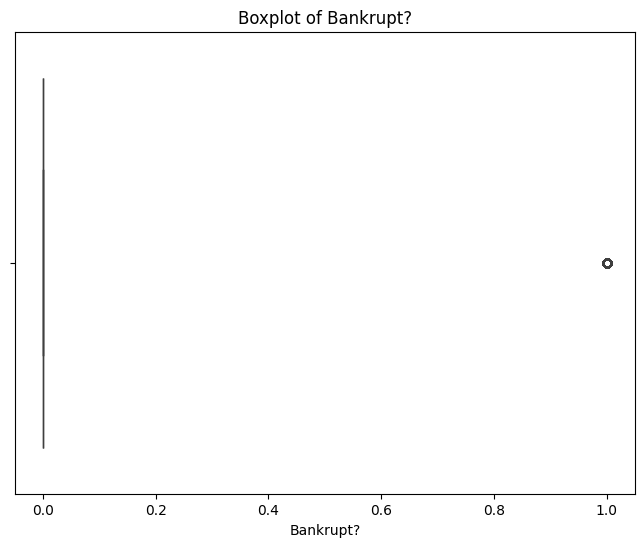

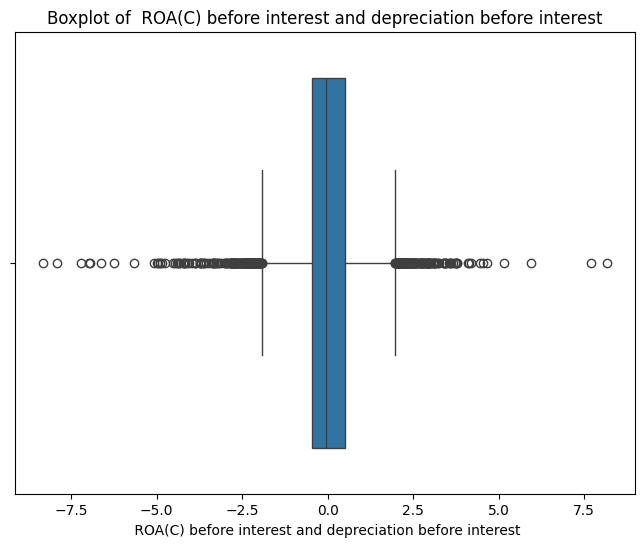

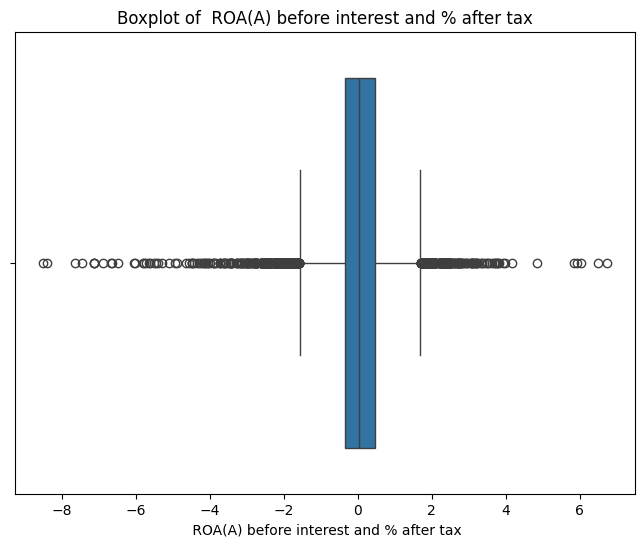

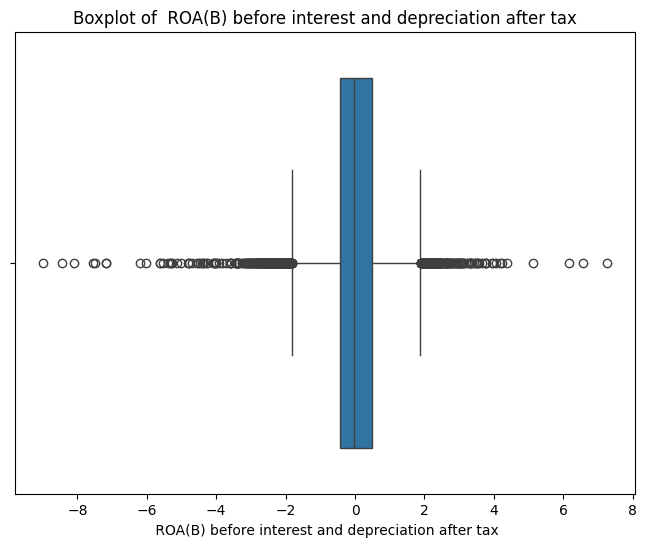

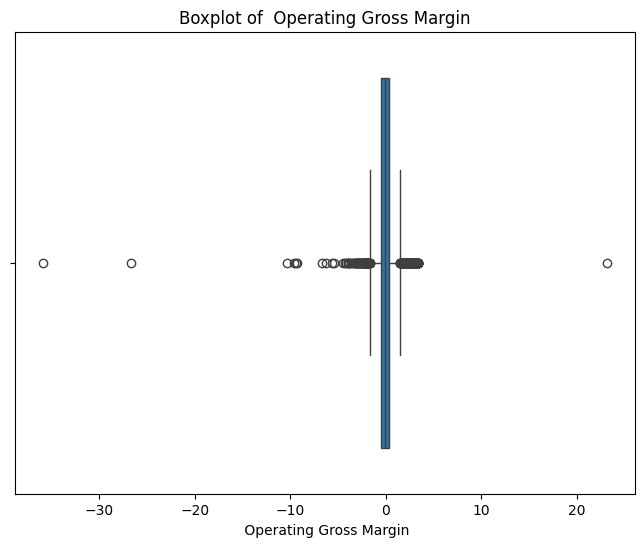

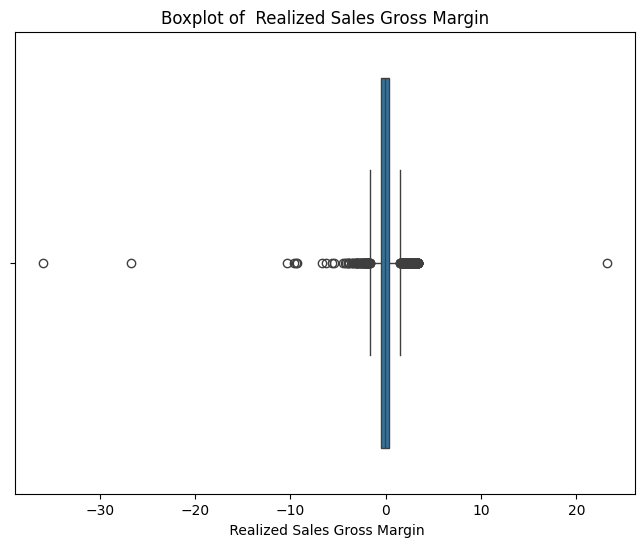

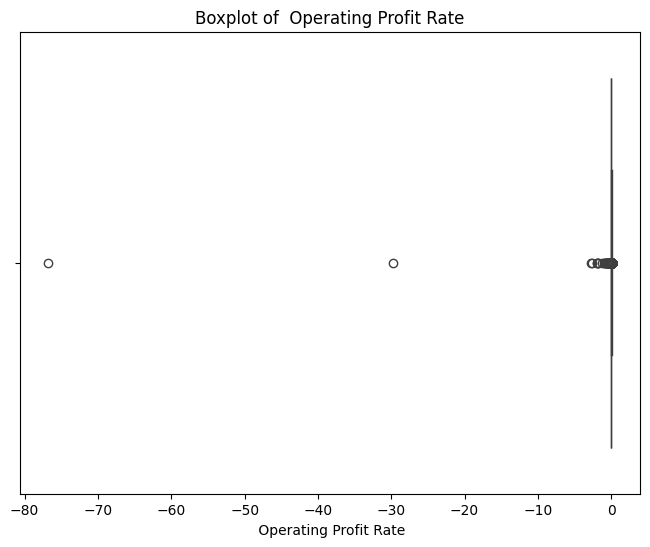

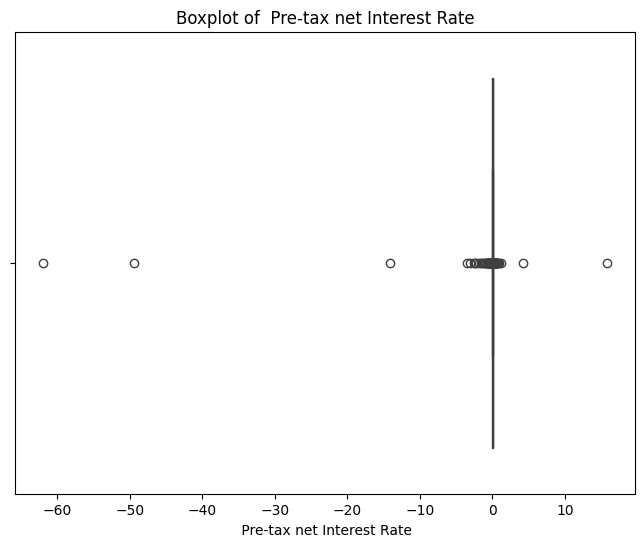

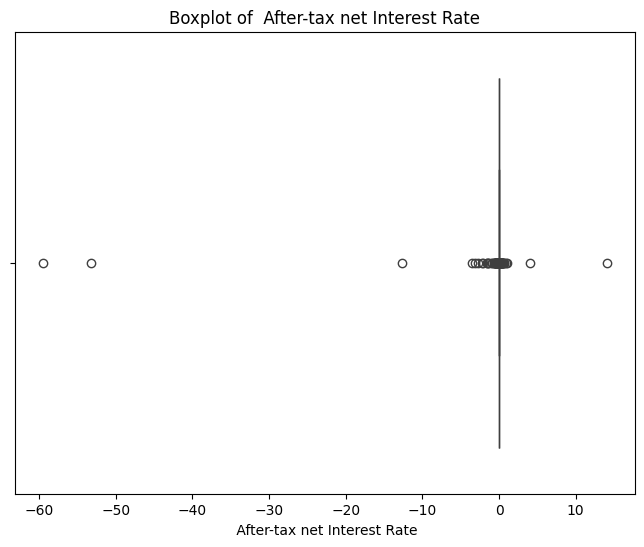

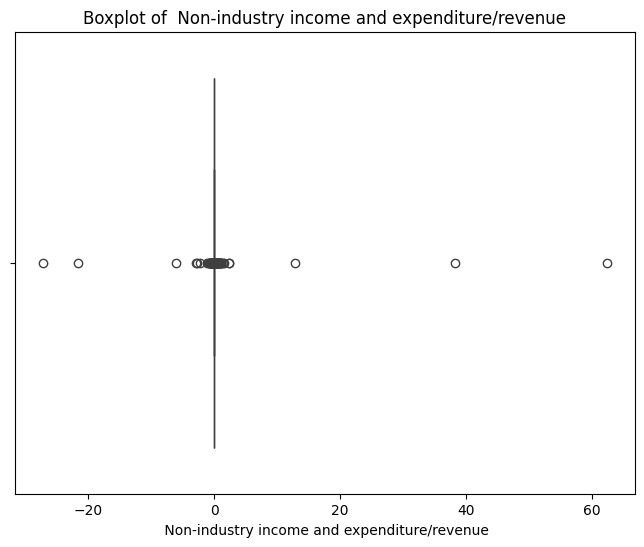

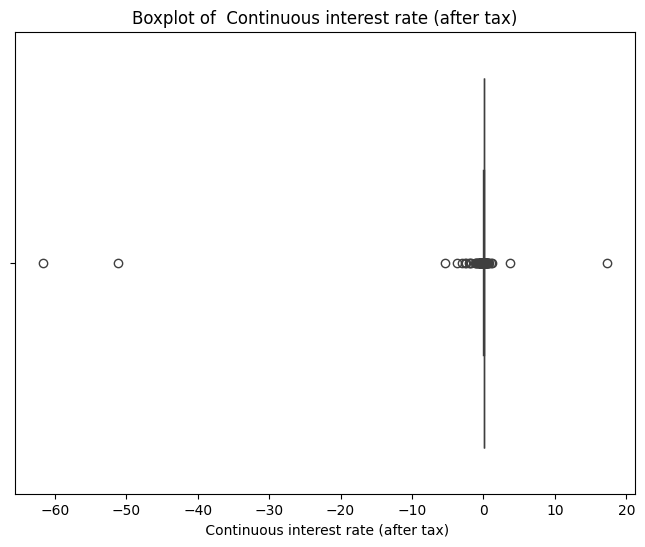

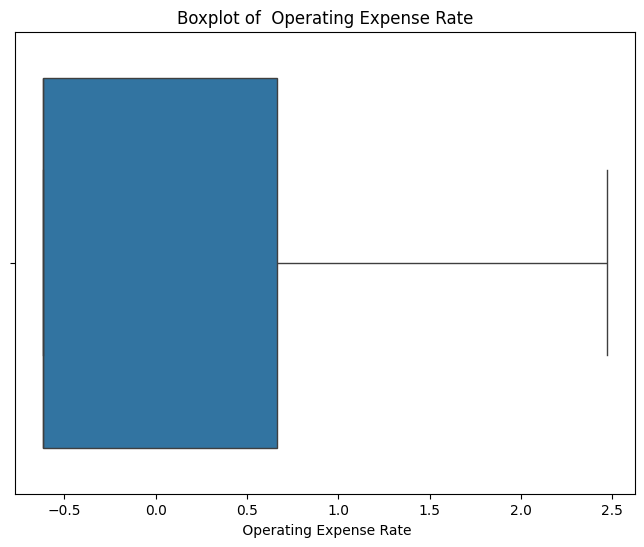

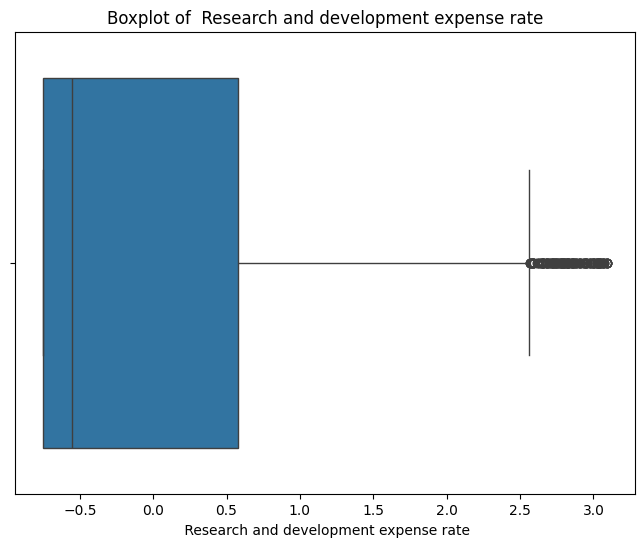

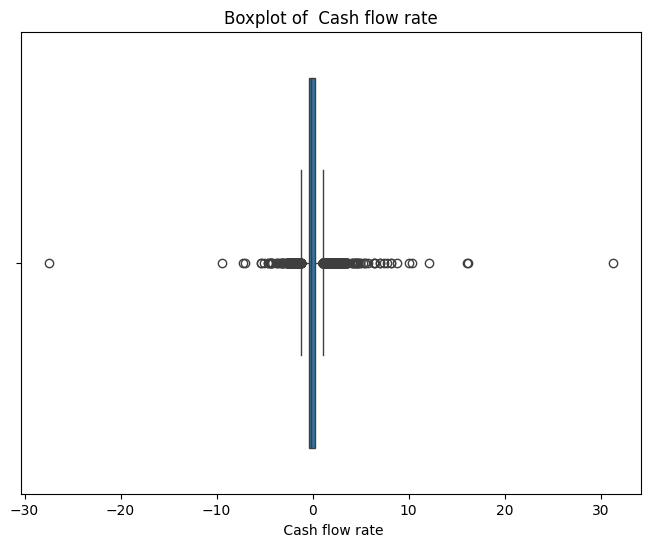

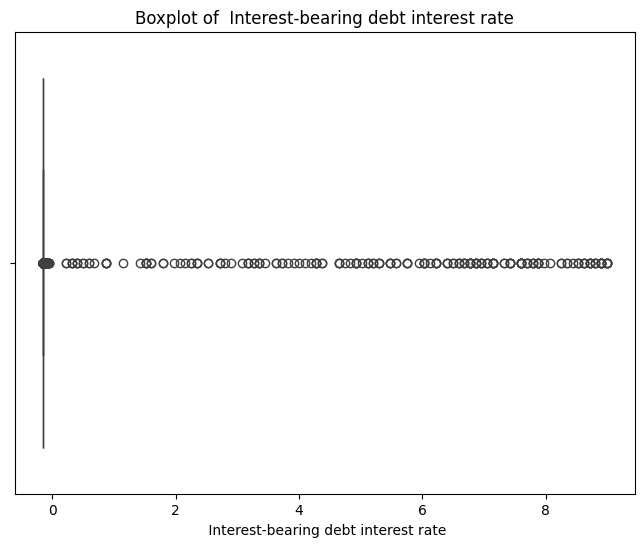

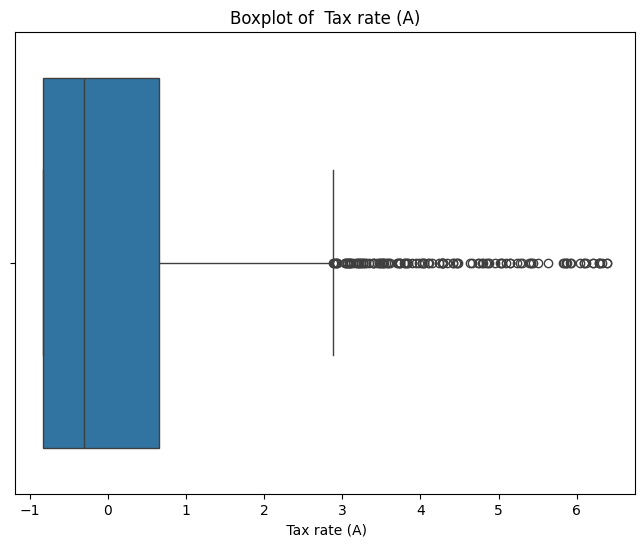

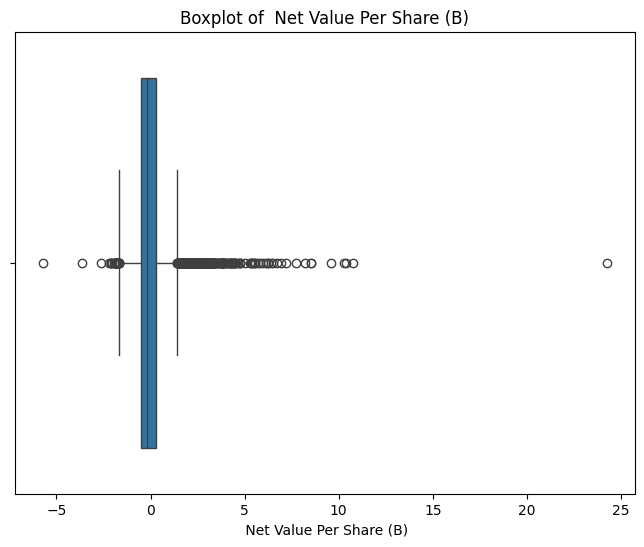

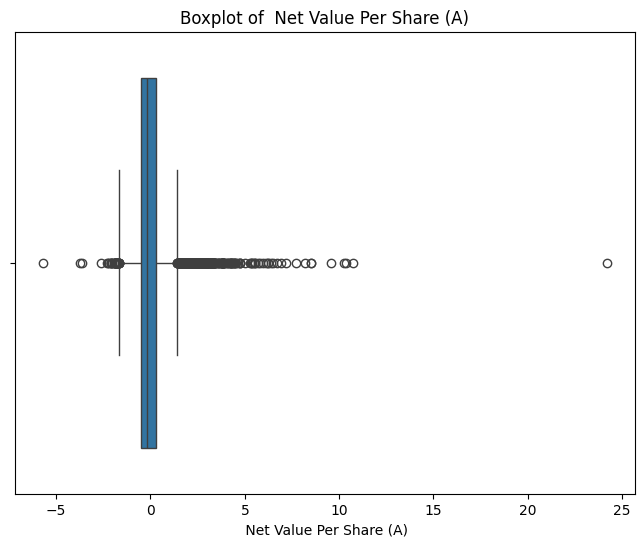

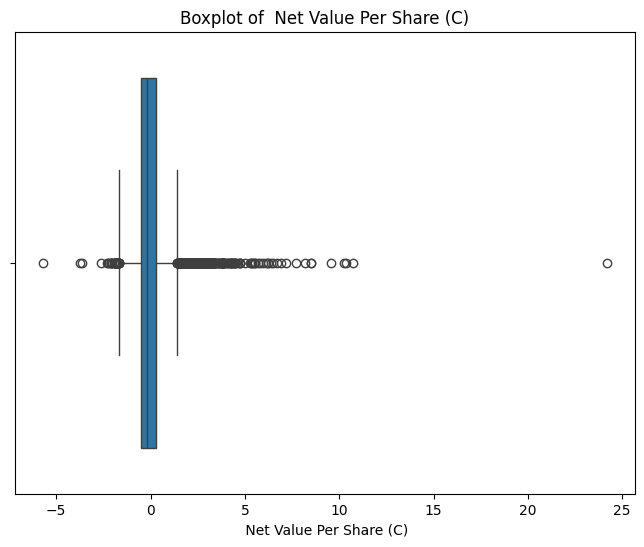

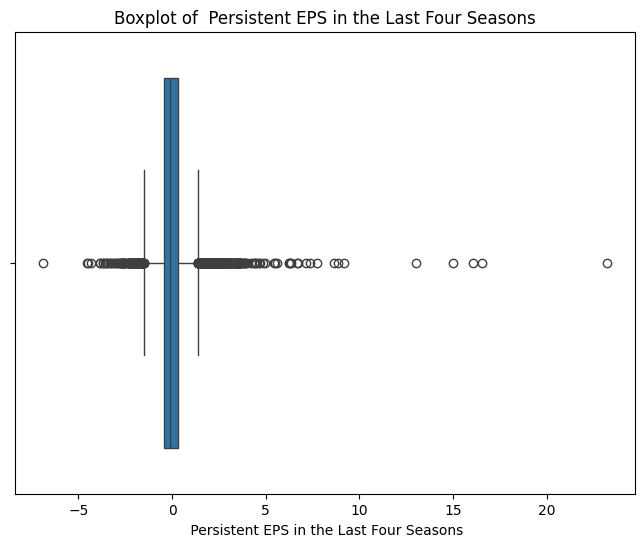

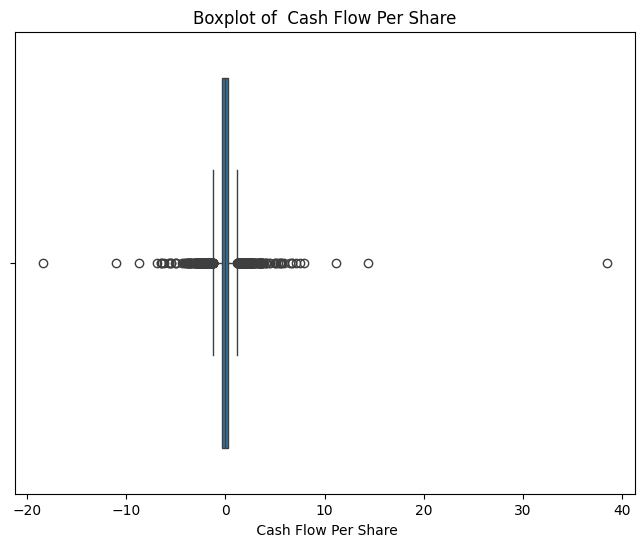

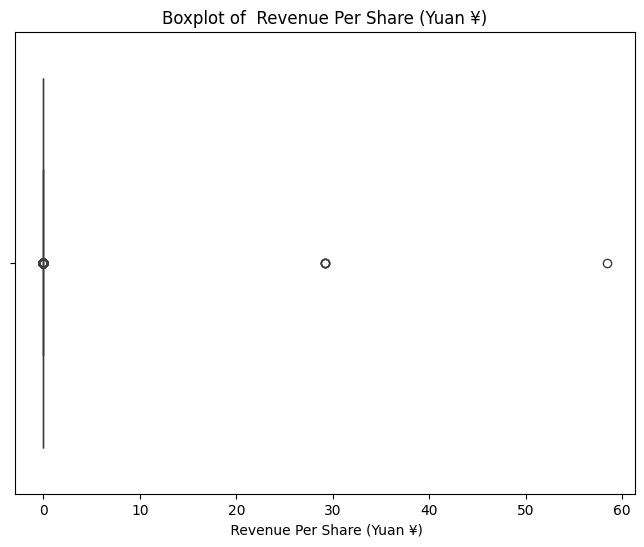

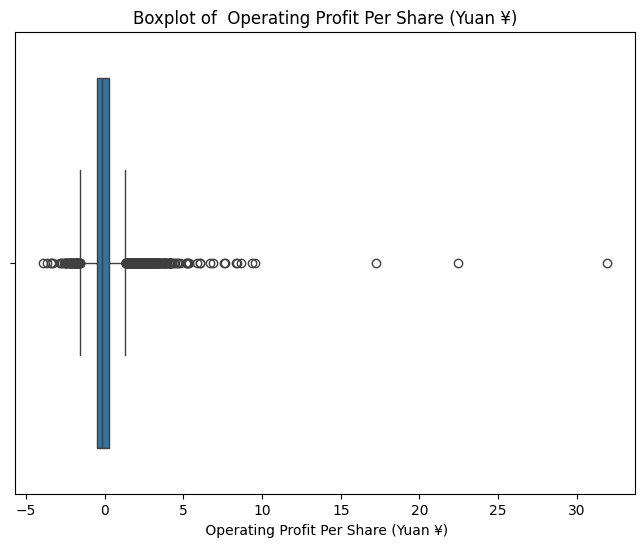

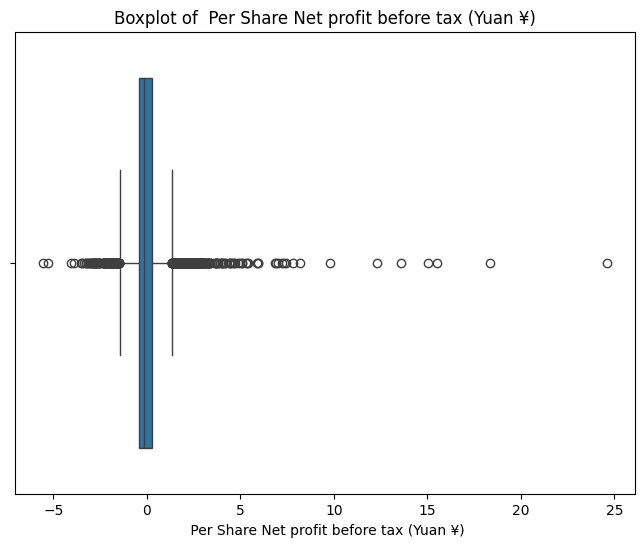

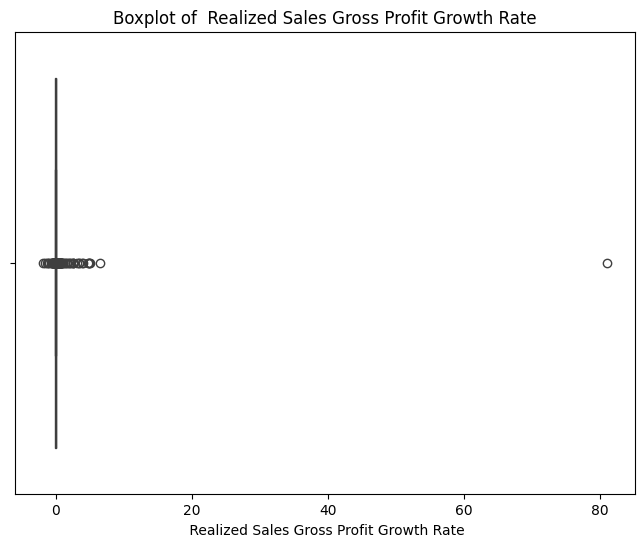

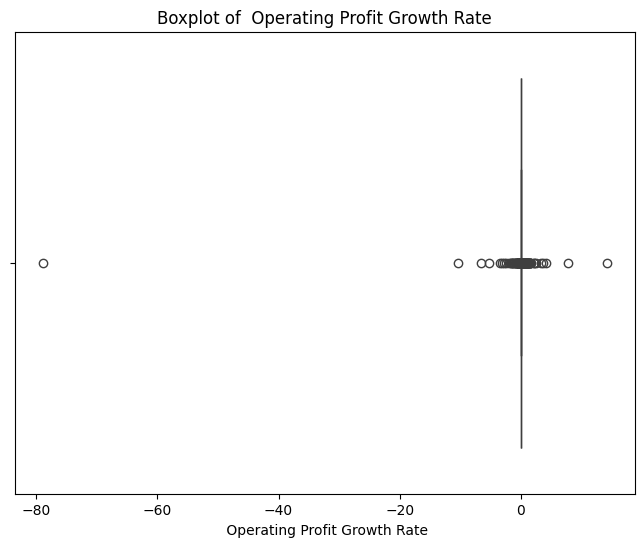

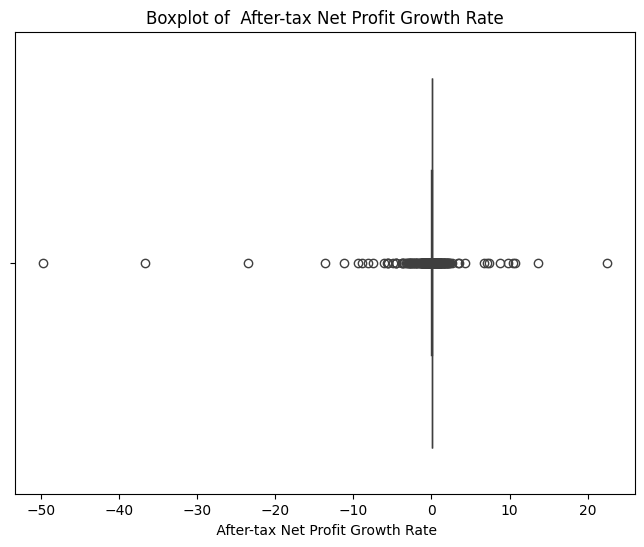

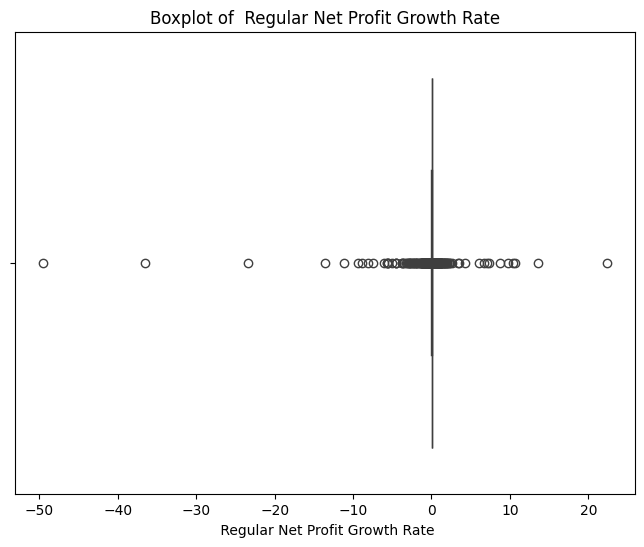

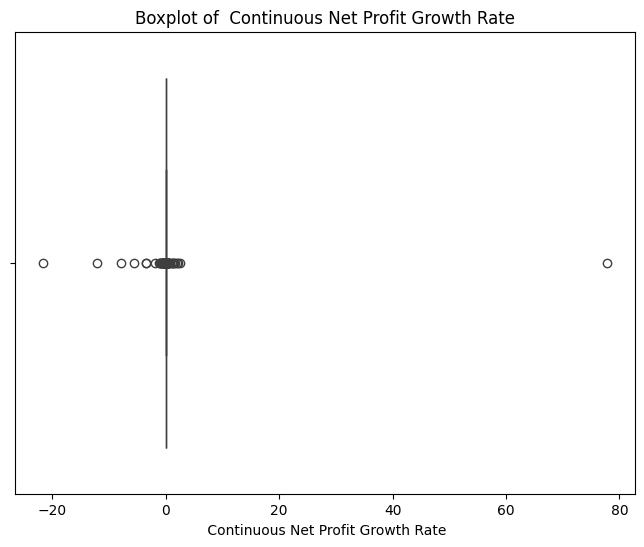

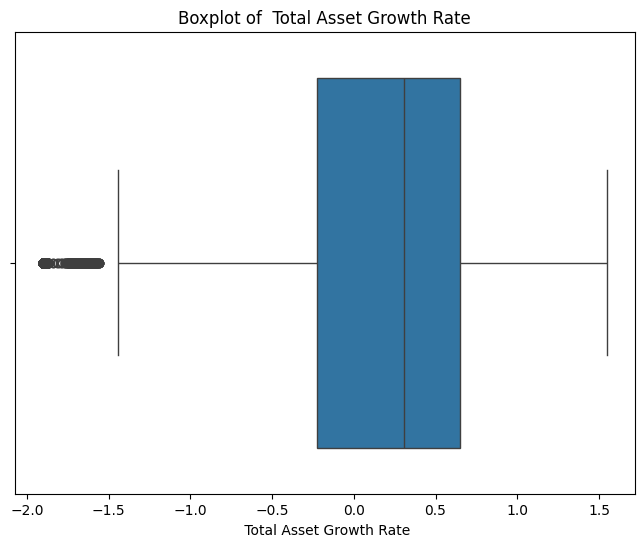

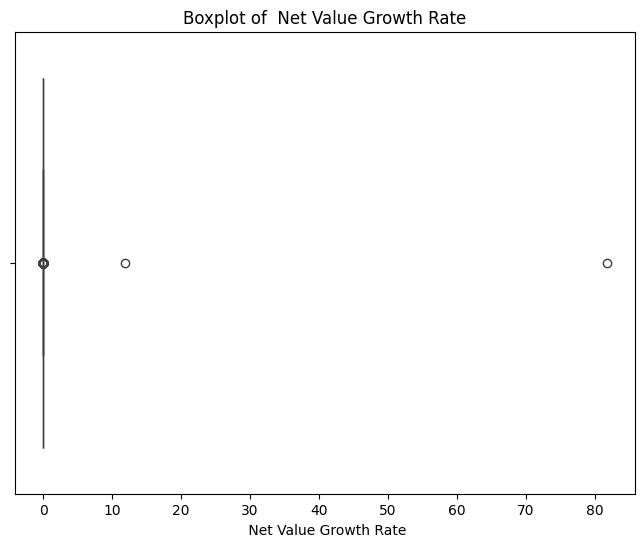

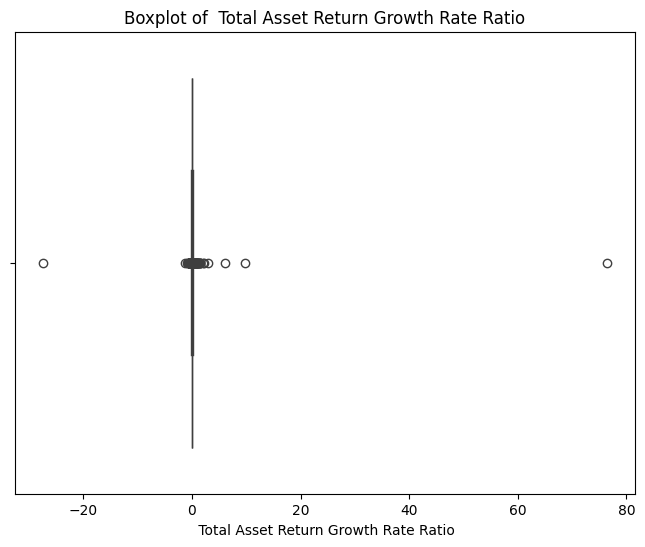

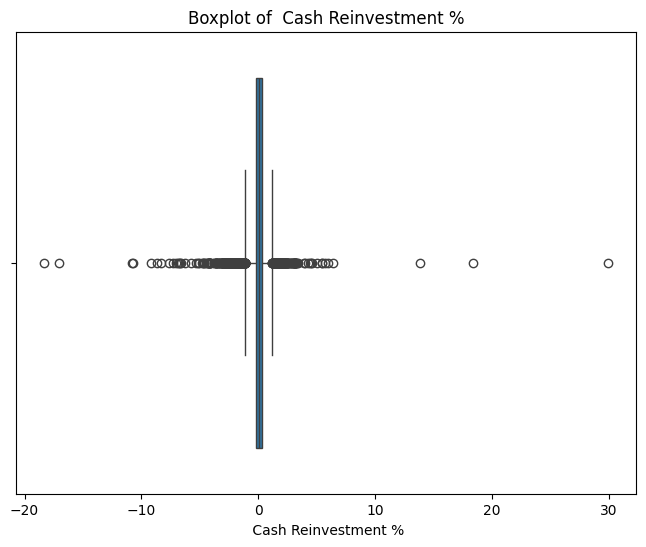

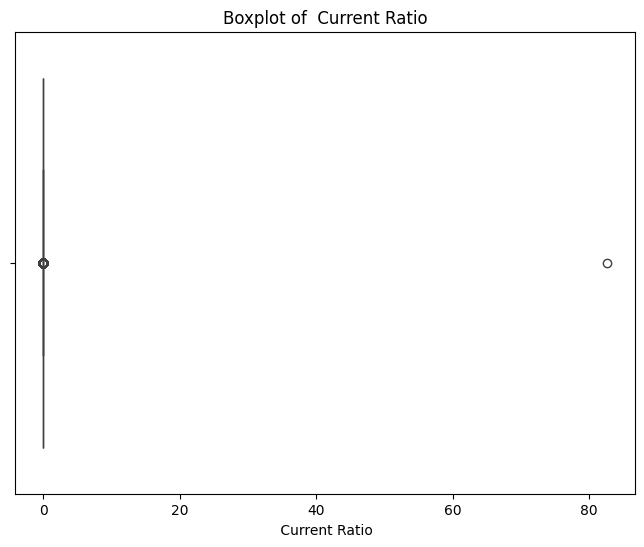

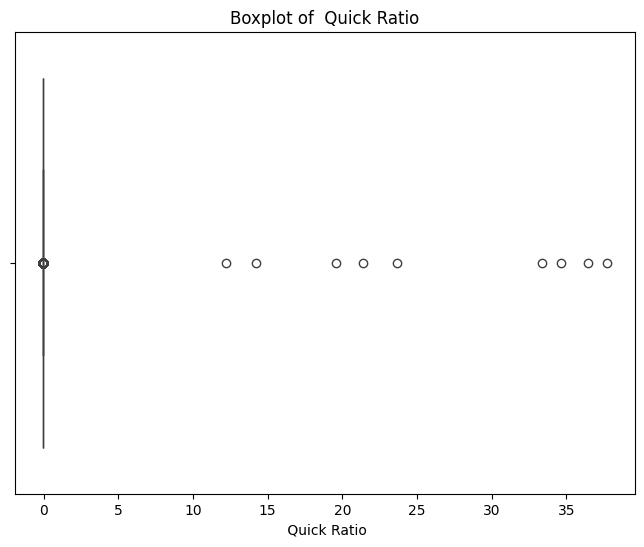

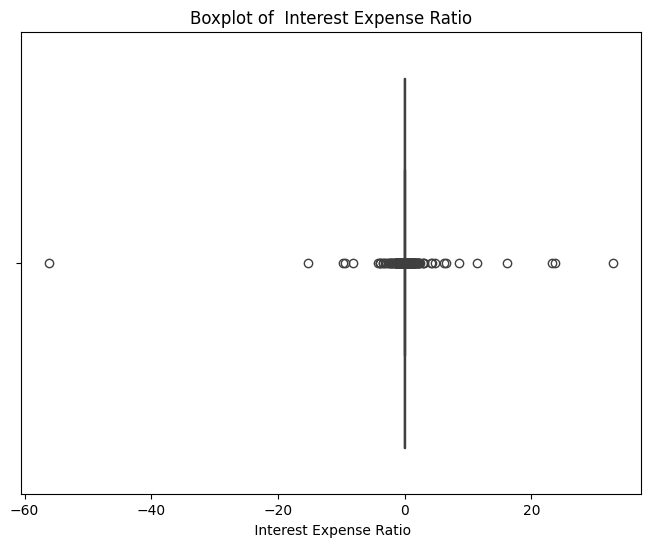

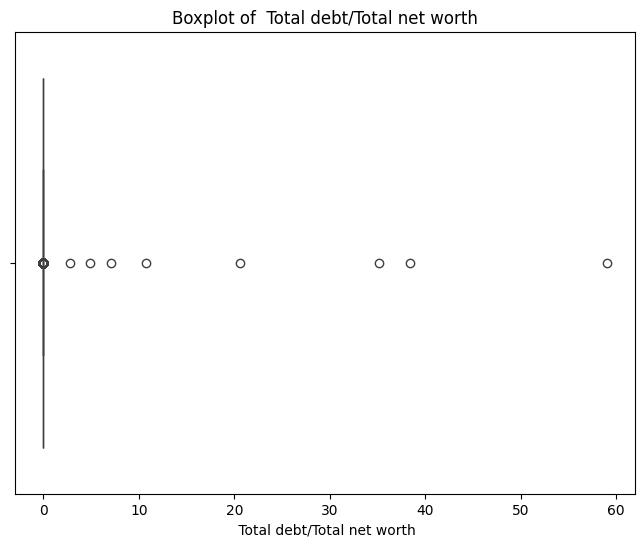

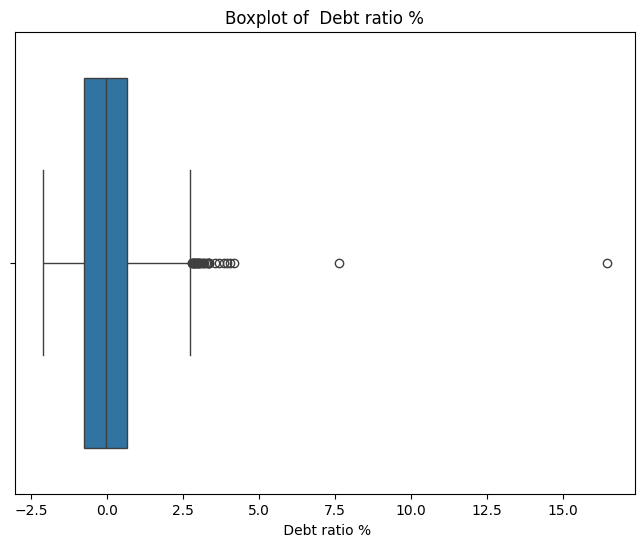

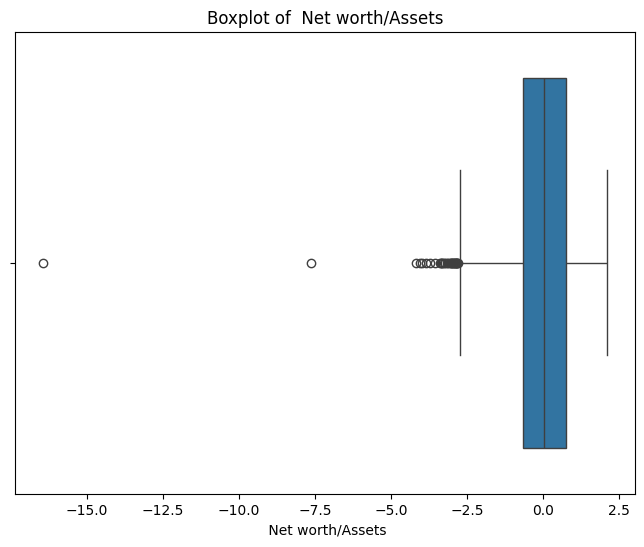

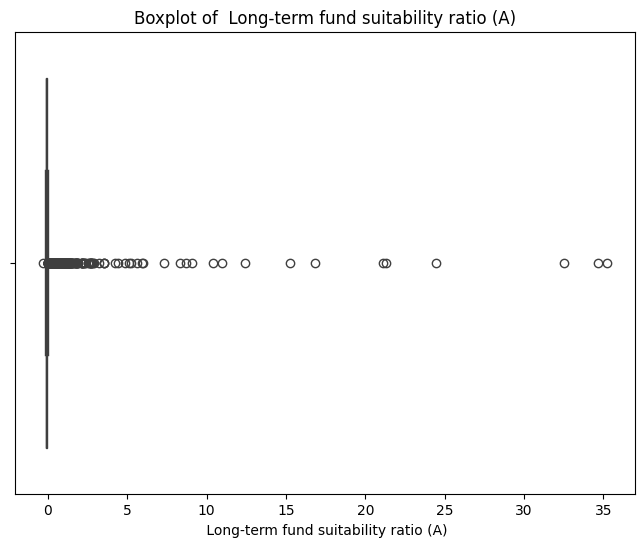

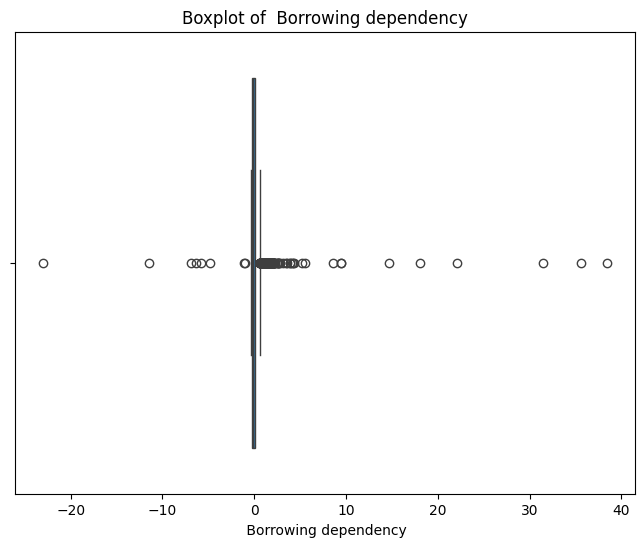

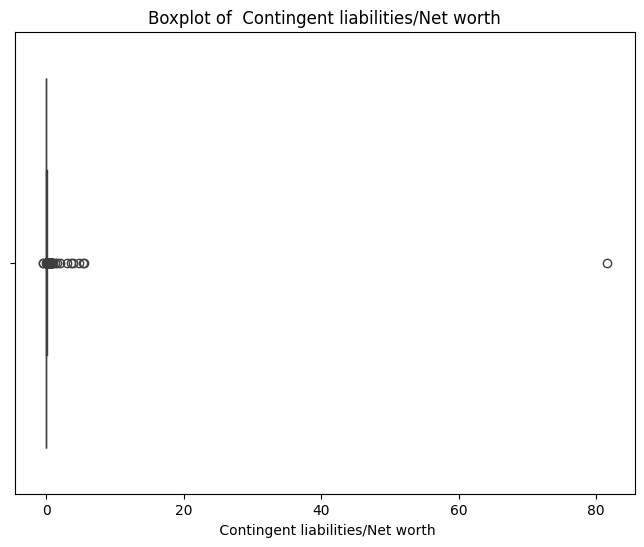

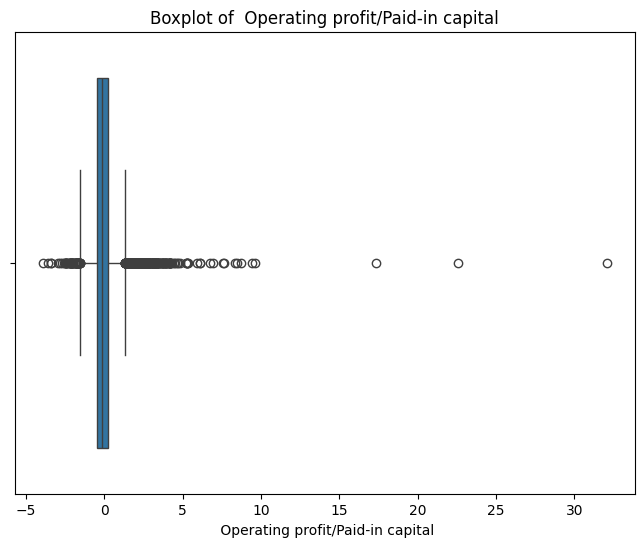

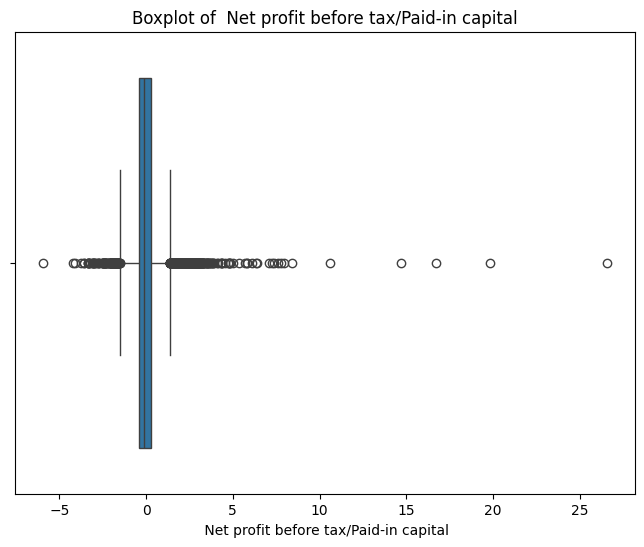

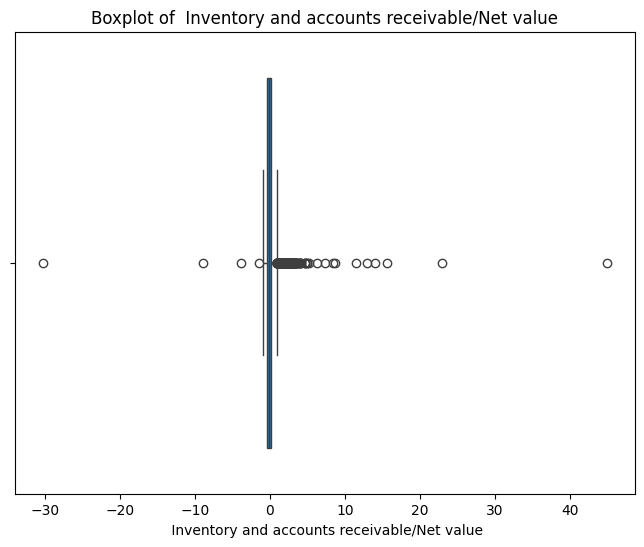

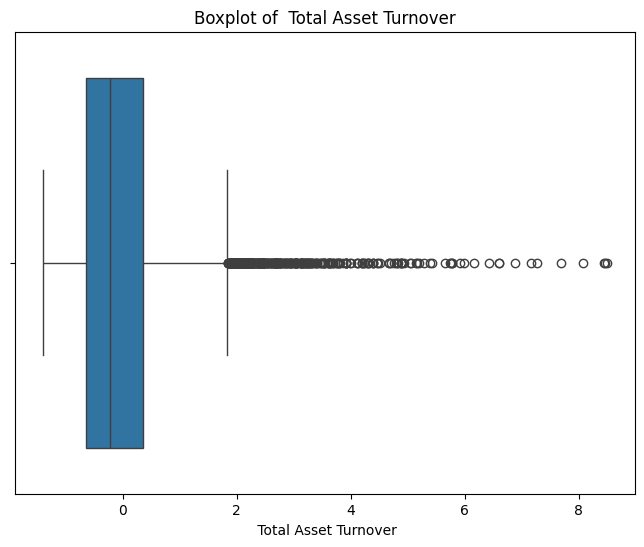

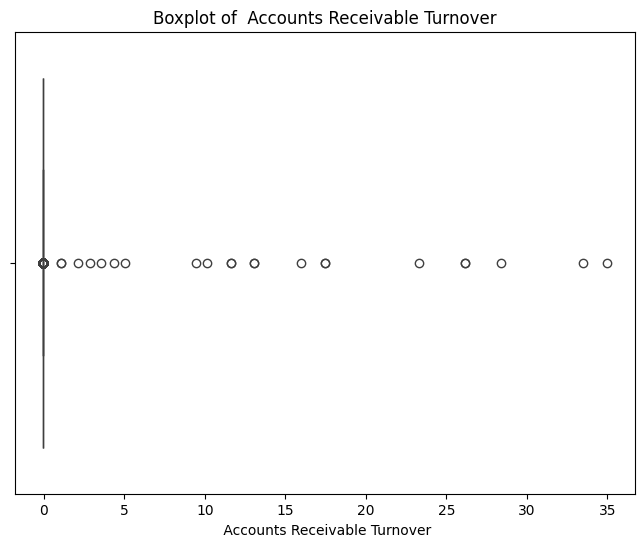

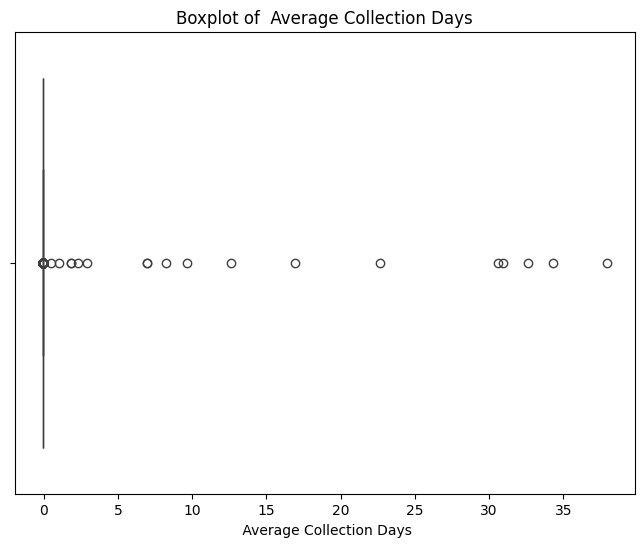

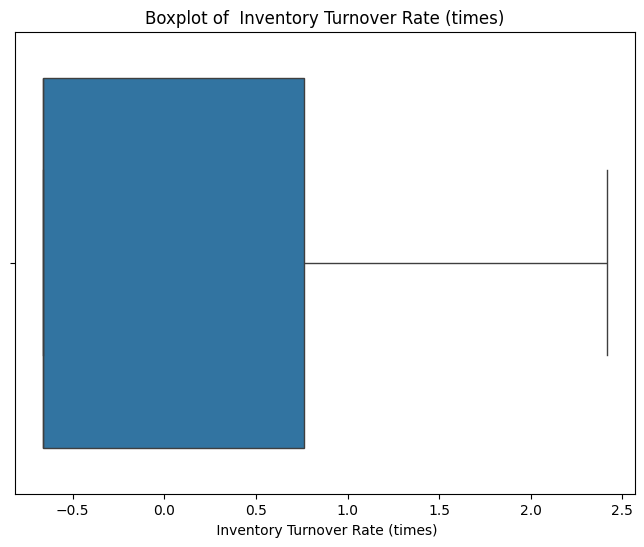

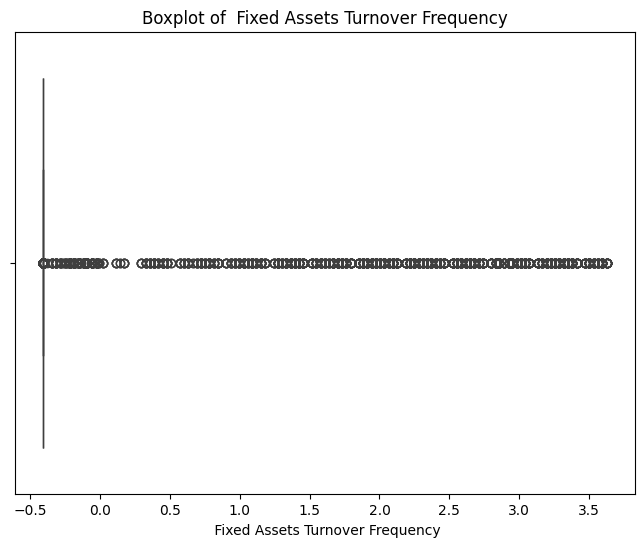

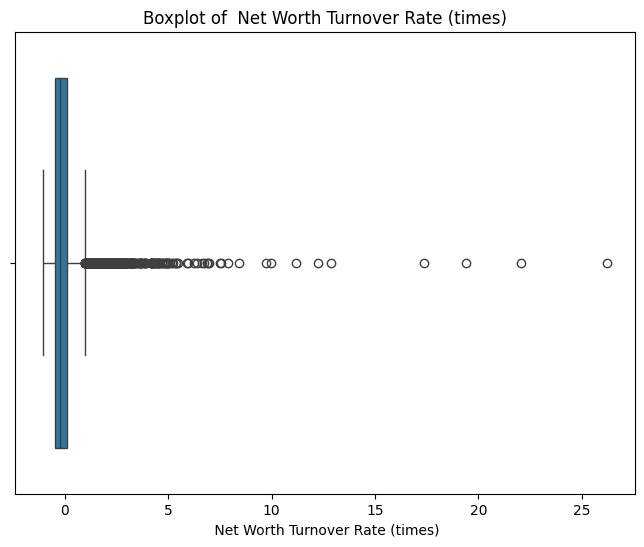

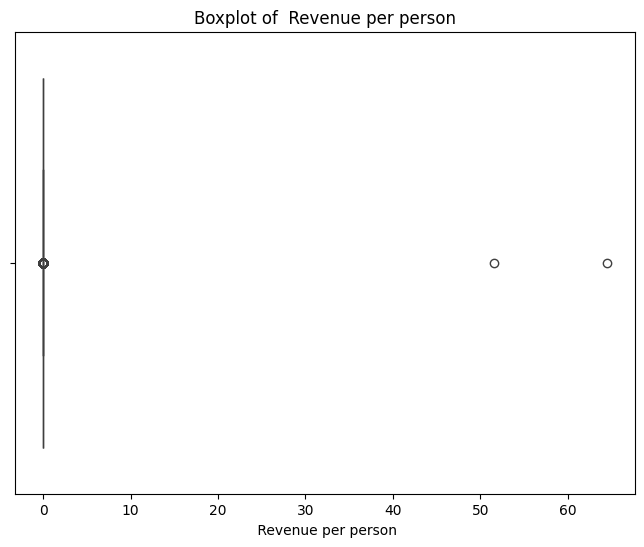

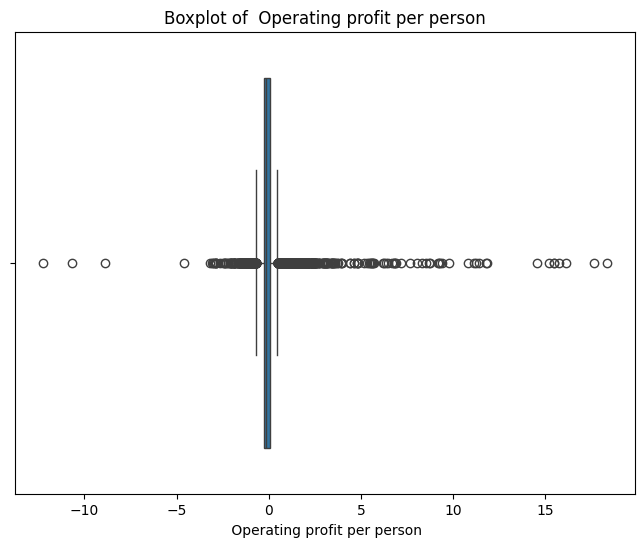

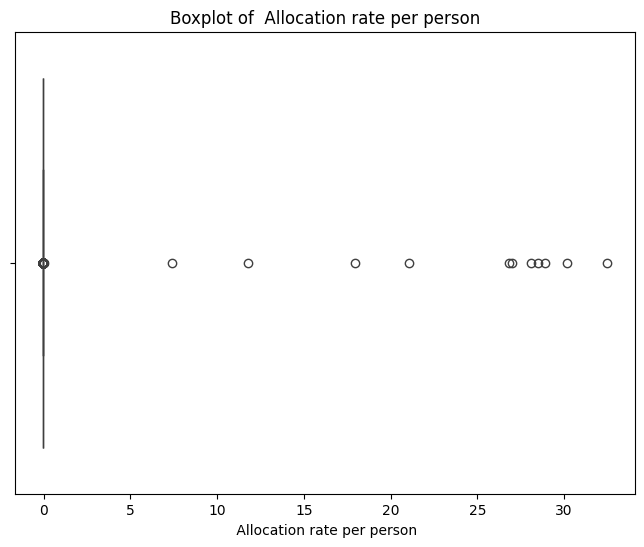

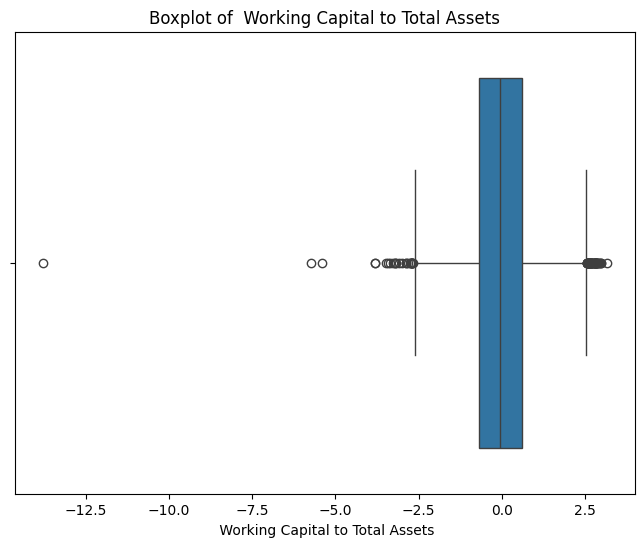

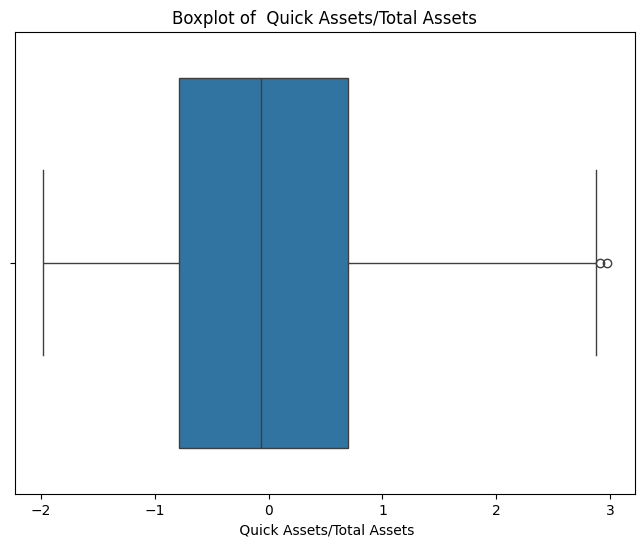

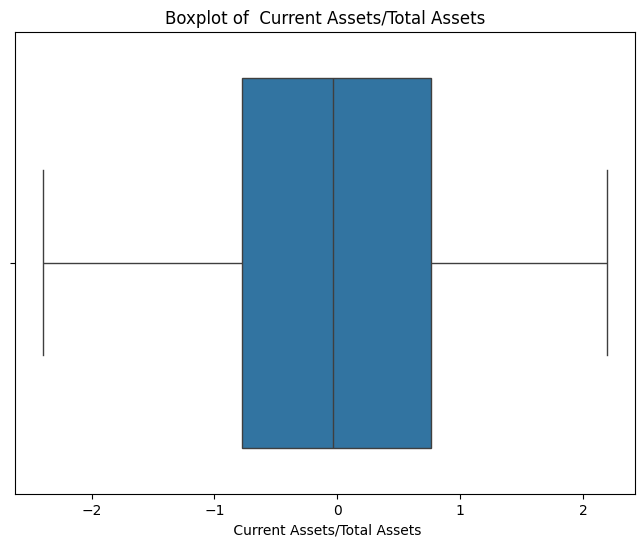

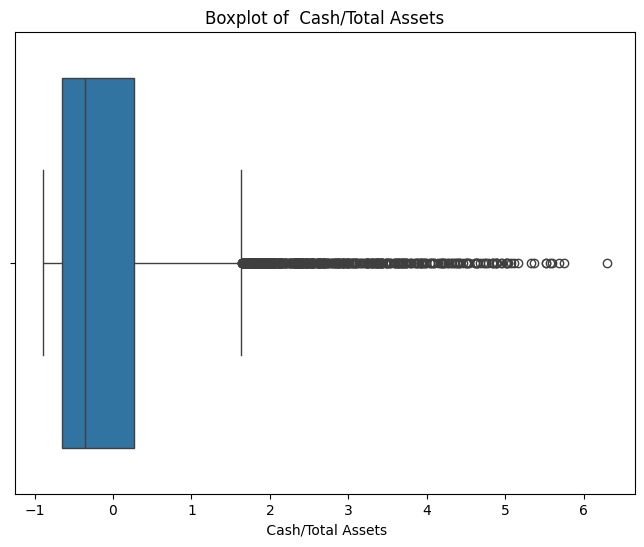

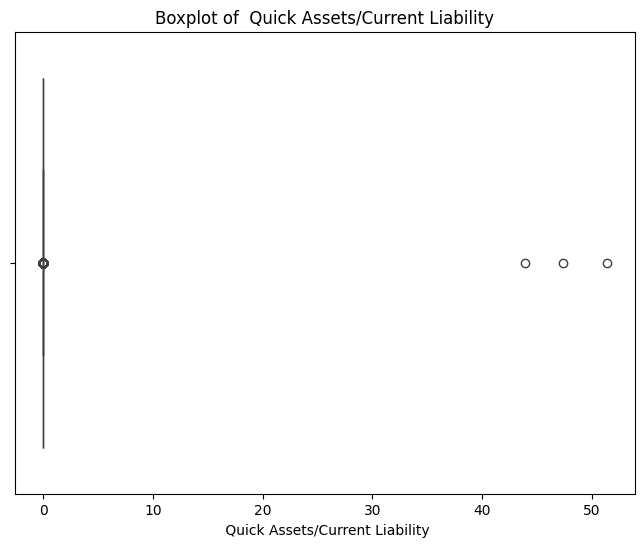

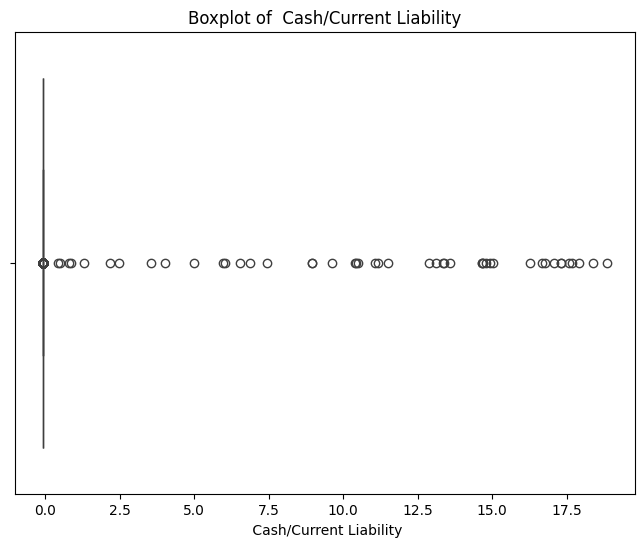

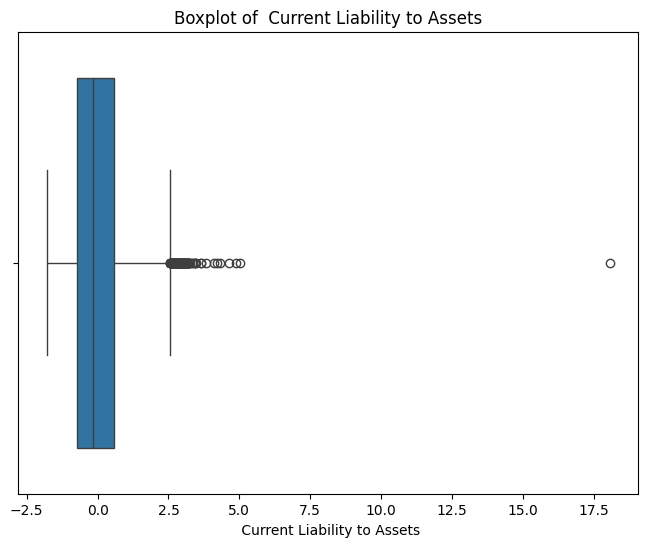

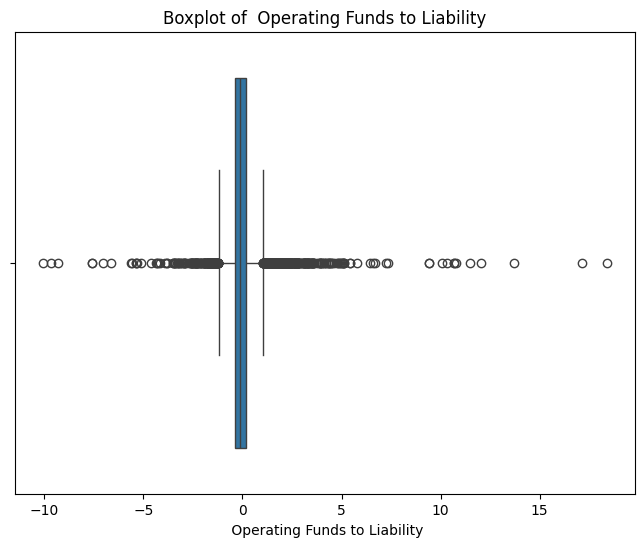

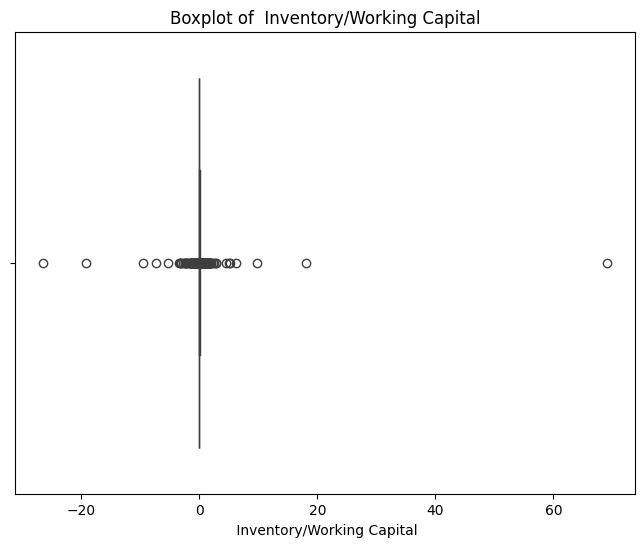

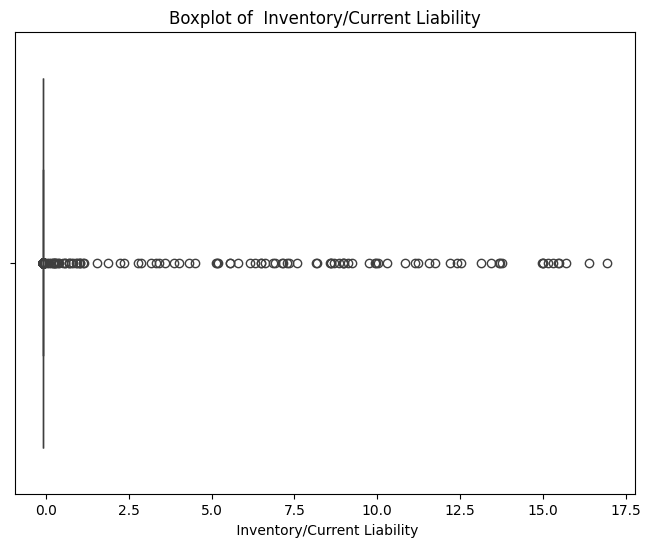

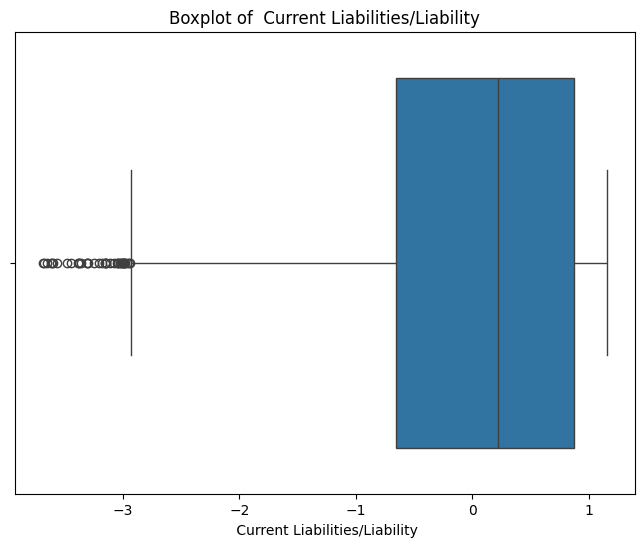

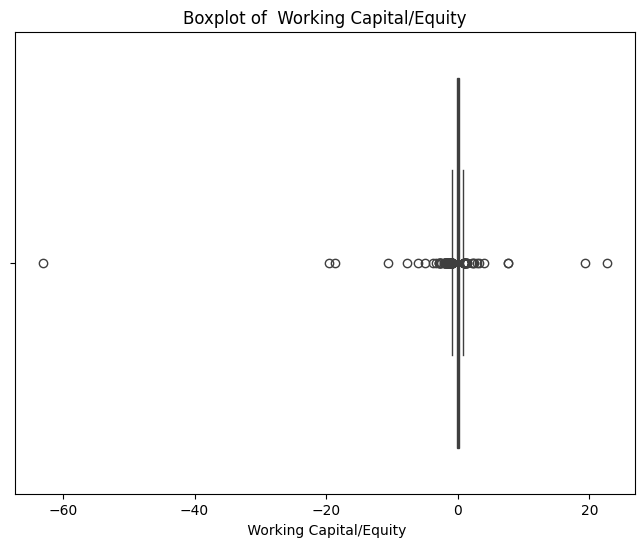

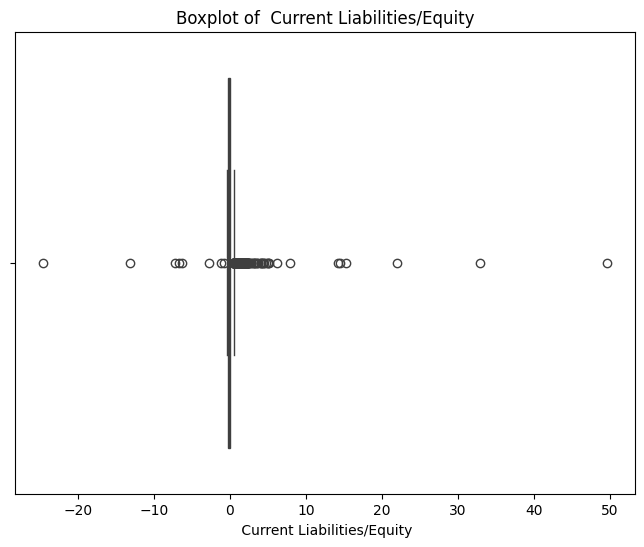

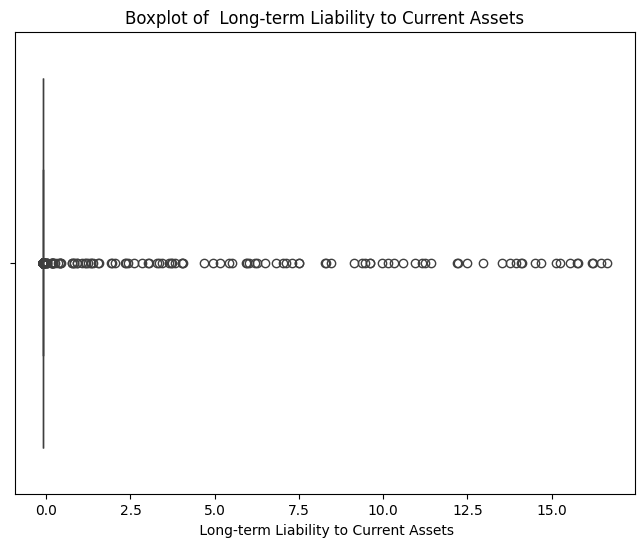

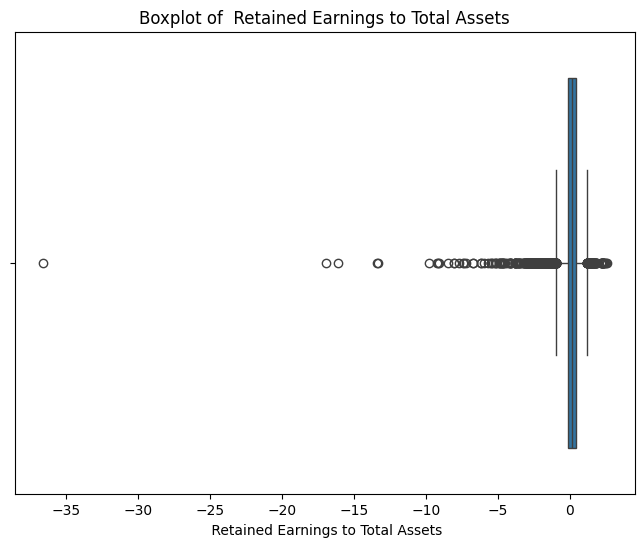

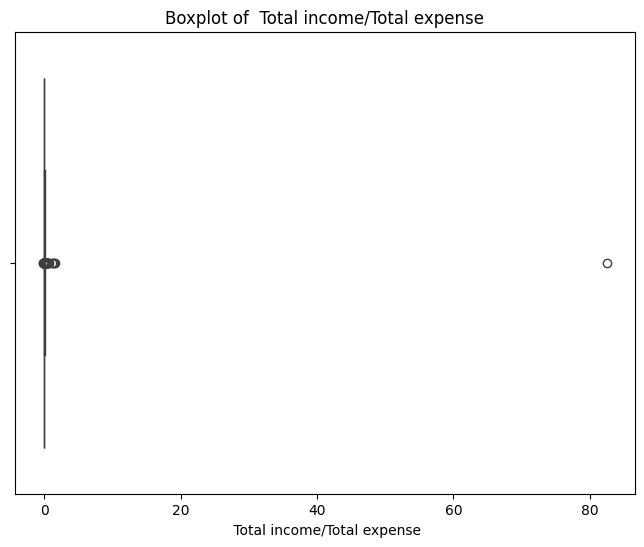

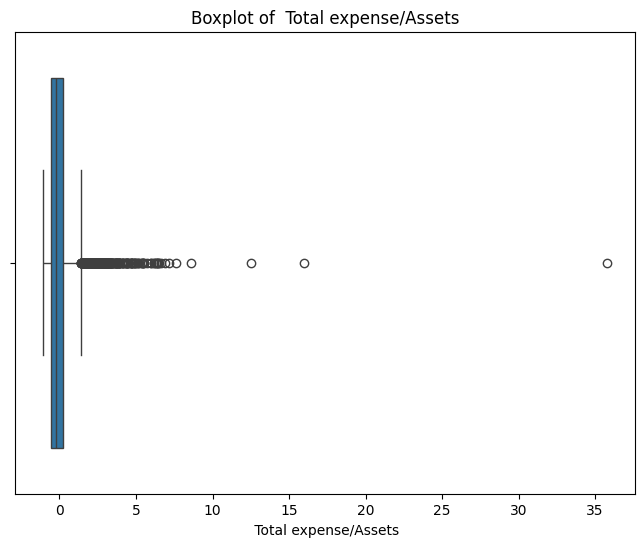

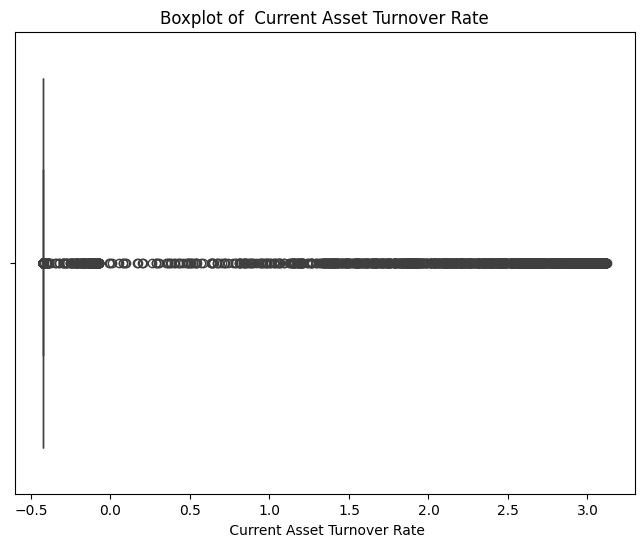

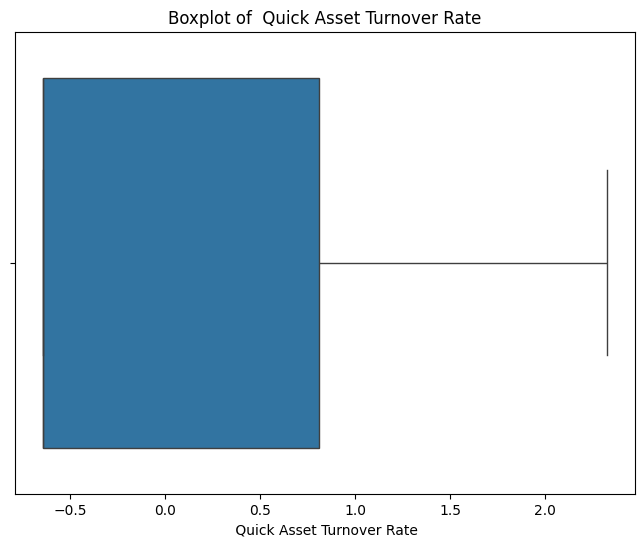

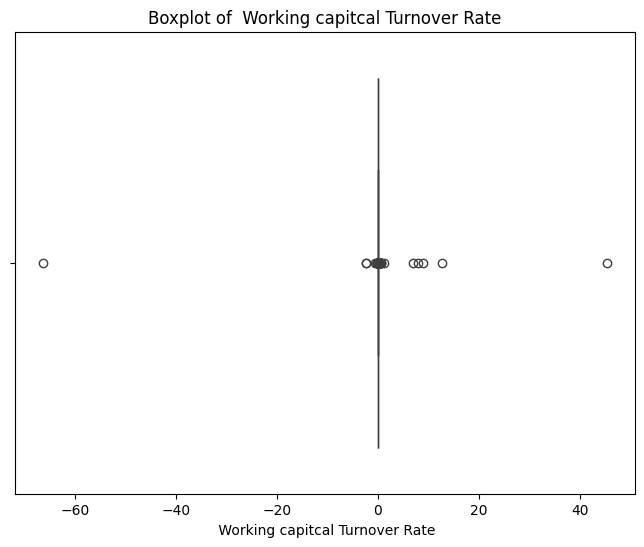

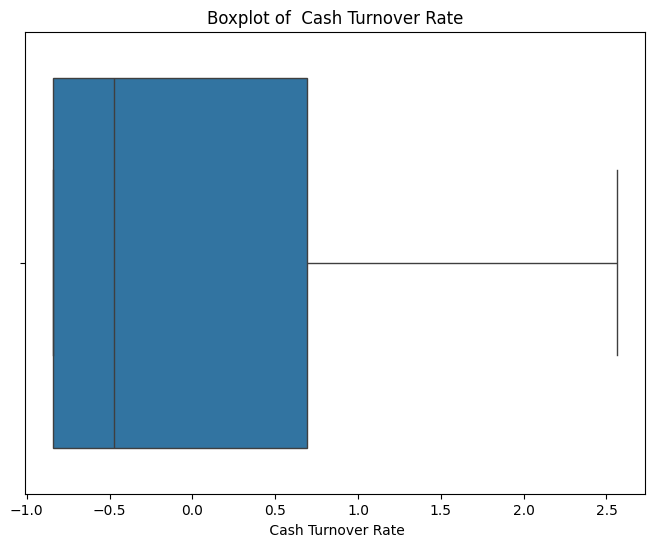

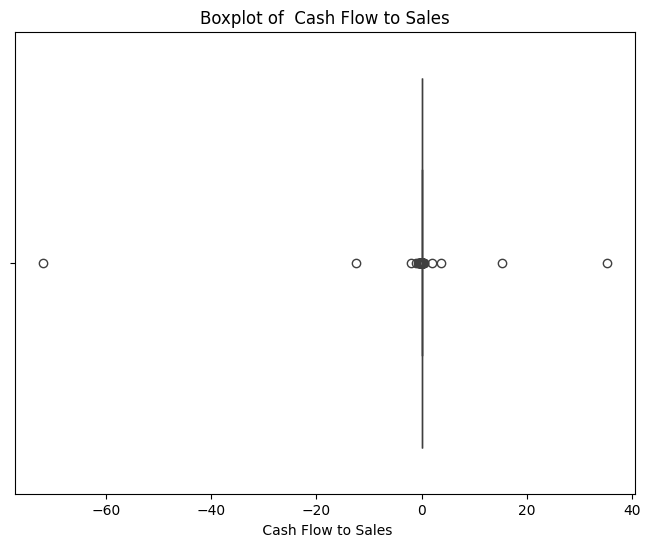

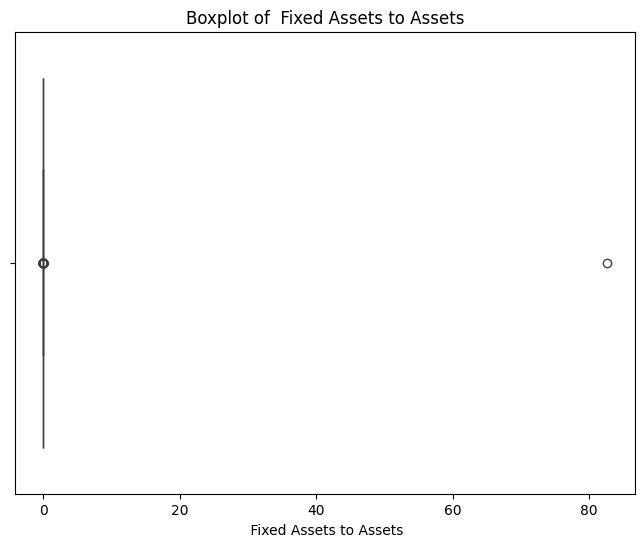

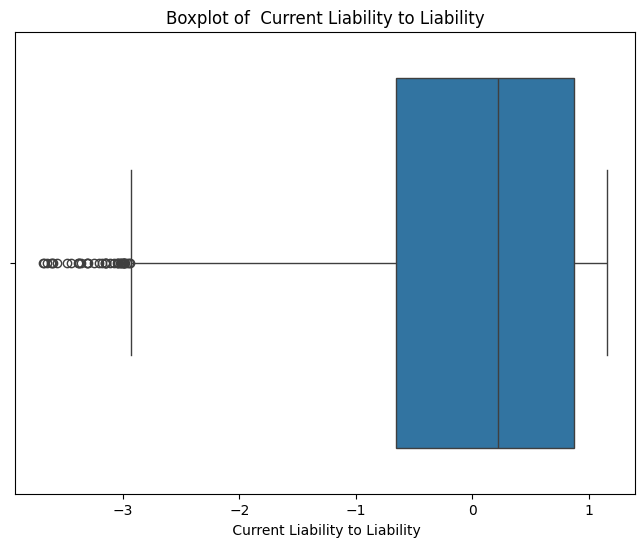

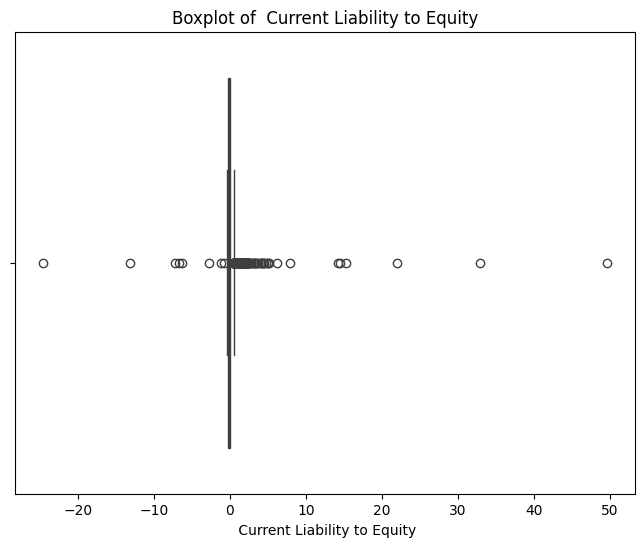

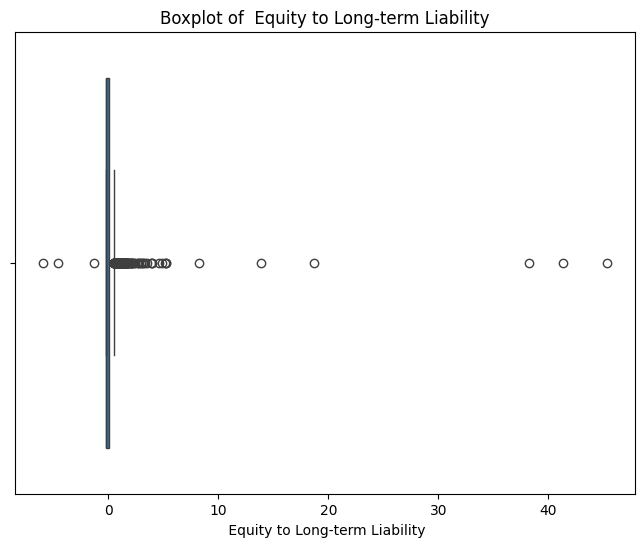

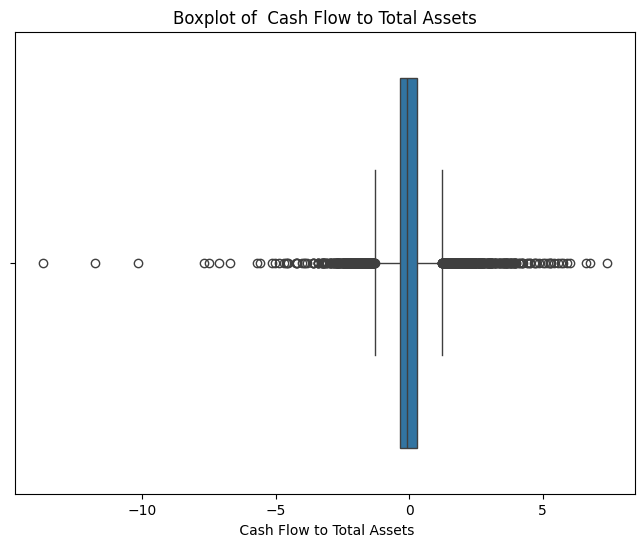

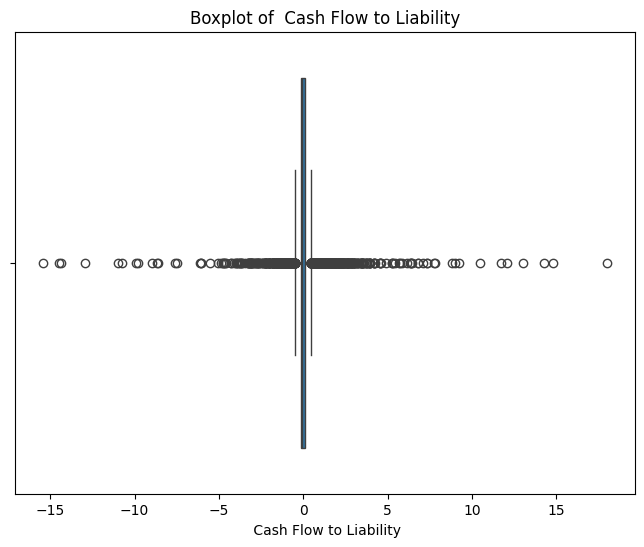

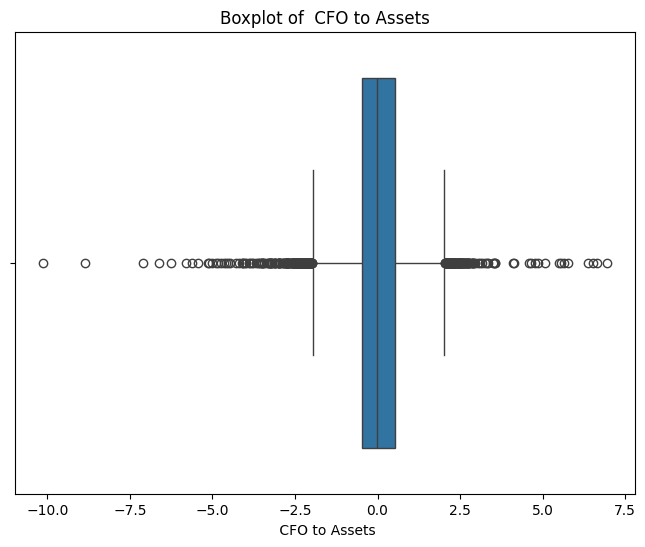

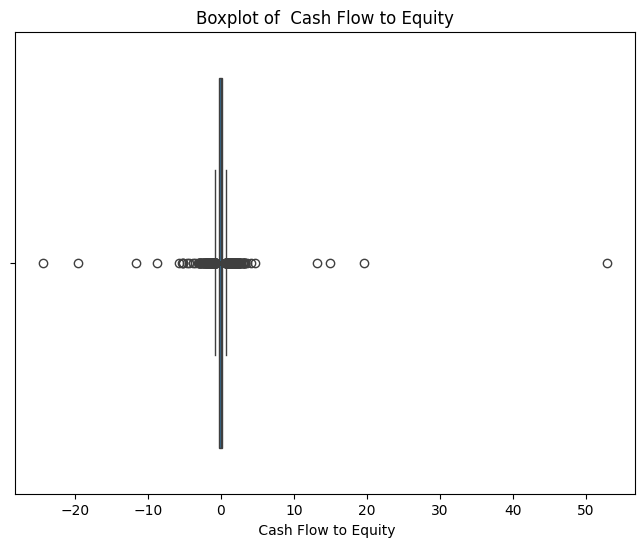

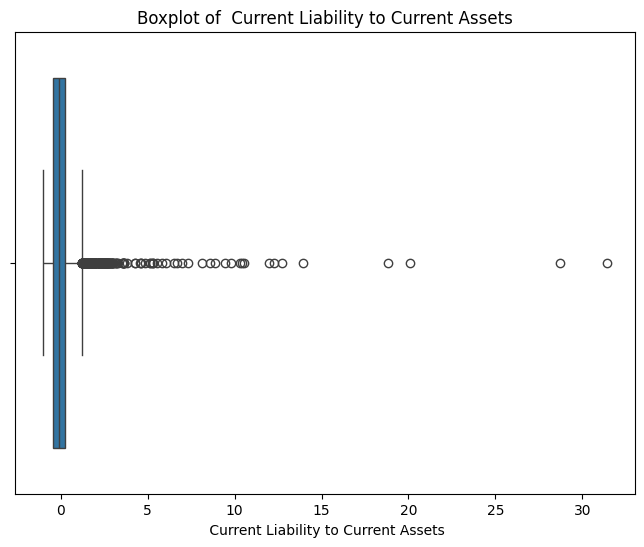

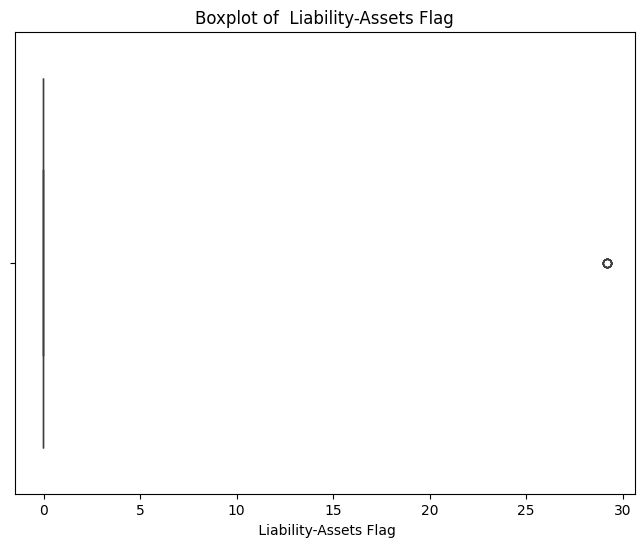

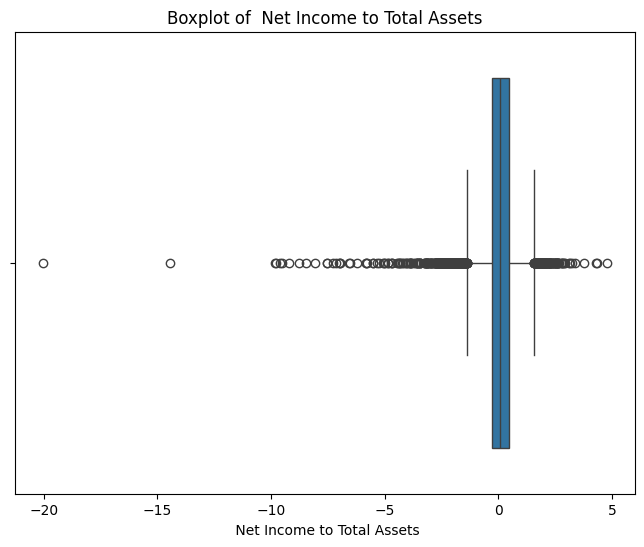

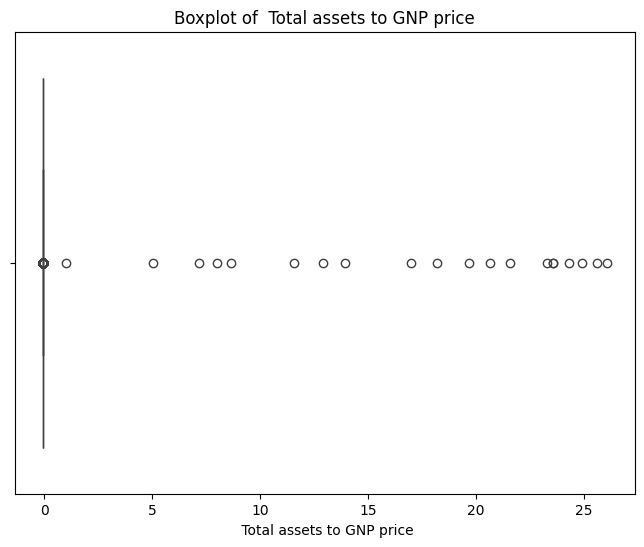

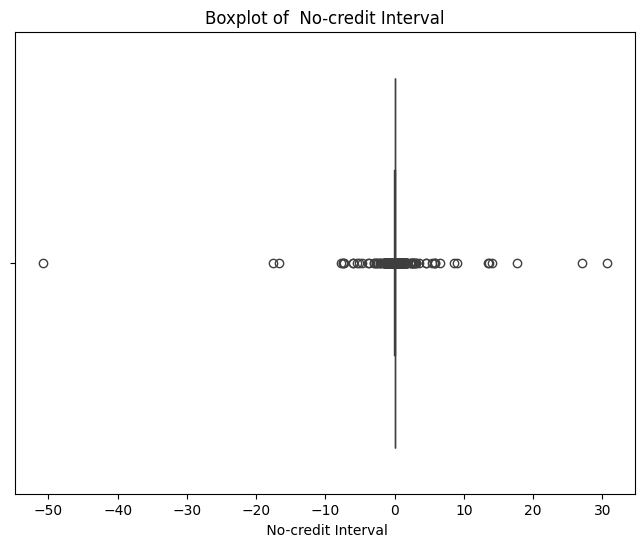

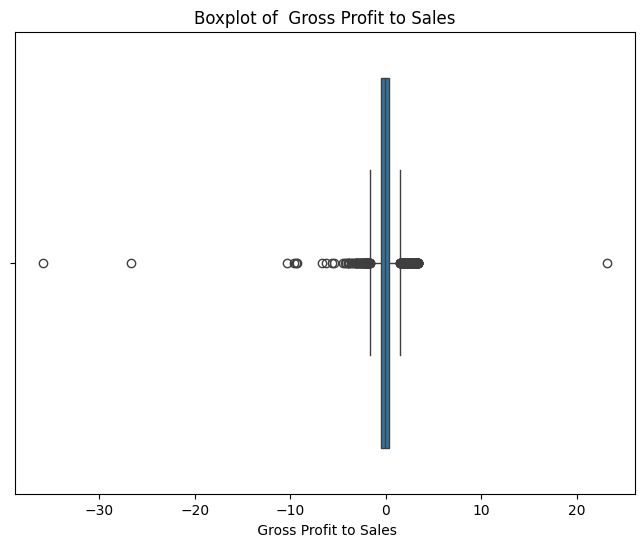

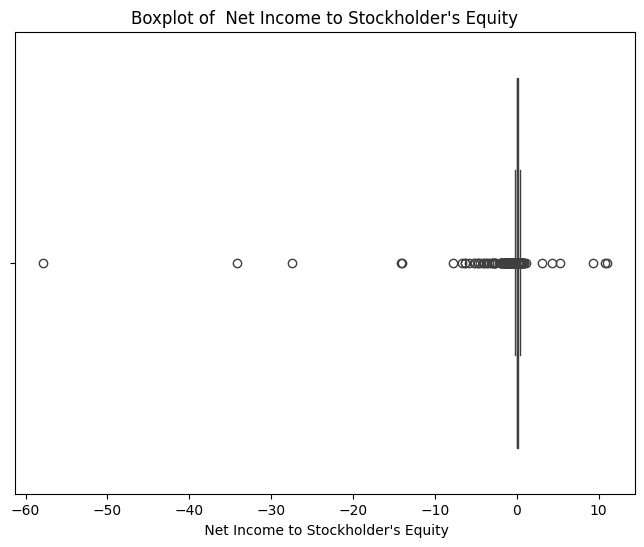

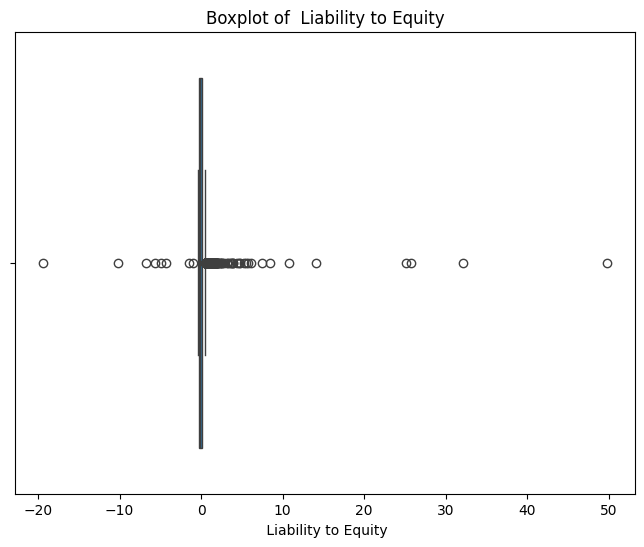

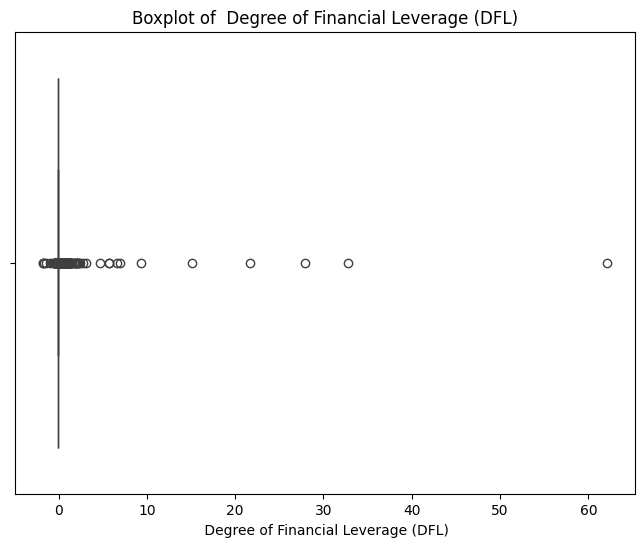

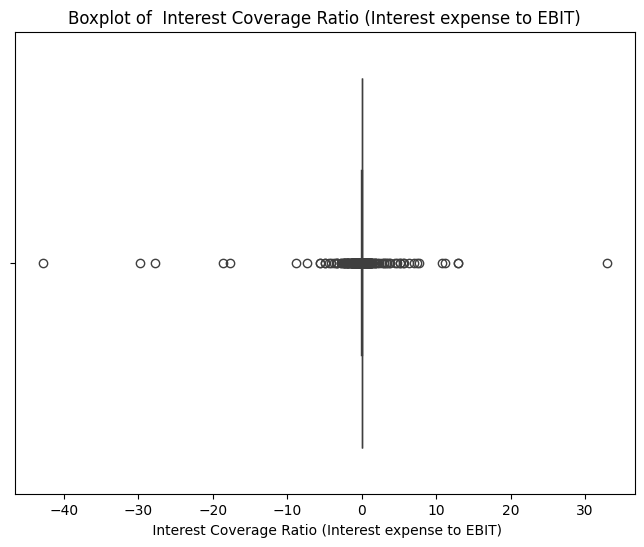

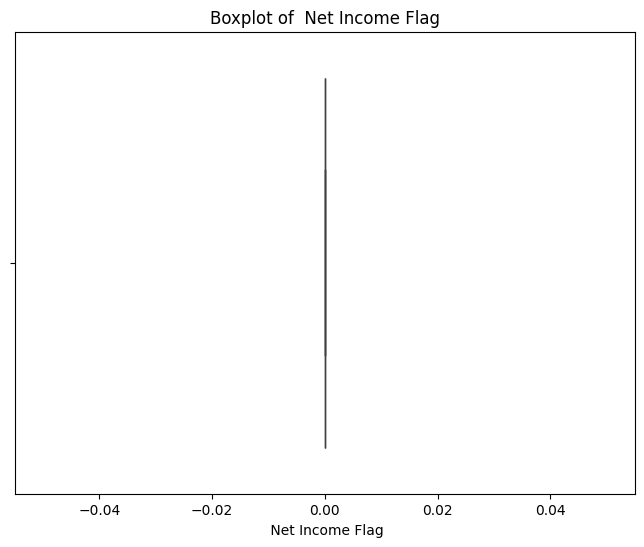

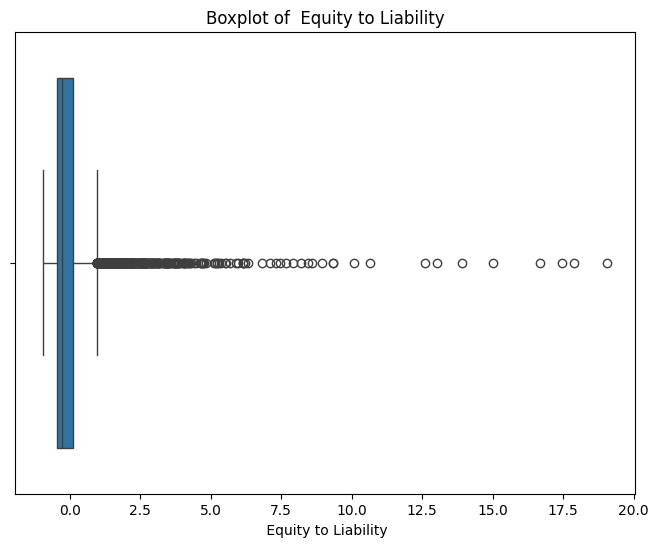

In [86]:
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=data[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

In [87]:
data

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                          -2.217909          
1             1                                          -0.673828          
2             1                                          -1.303672          
3             1                                          -1.735886          
4             1                                          -0.661778          
...         ...                                                ...          
6814          0                                          -0.189395          
6815          0                                          -0.494676          
6816          0                                          -0.534845          
6817          0                                           0.017875          
6818          0                                          -0.199839          

       ROA(A) before interest and % after tax  \
0                                   -2.045798   
1                                   -0.311068   
2                                   -0.908420   
3                                   -1.636209   
4                                   -0.307745   
...                                       ...   
6814                                -0.291959   
6815                                -0.310237   
6816                                -0.379194   
6817                                 0.019594   
6818                                 0.174956   

       ROA(B) before interest and depreciation after tax  \
0                                             -2.400361    
1                                             -0.598450    
2                                             -1.319910    
3                                             -1.556340    
4                                             -0.508050    
...                                                 ...    
6814                                          -0.168181    
6815                                          -0.477627    
6816                                          -0.534996    
6817                                           0.007403    
6818                                          -0.065612    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                   -0.383334                     -0.382638   
1                    0.135068                      0.136307   
2                   -0.383759                     -0.388177   
3                   -1.441418                     -1.441832   
4                   -0.541238                     -0.540708   
...                       ...                           ...   
6814                -0.206277                     -0.204969   
6815                -0.569328                     -0.568828   
6816                 0.147411                      0.135029   
6817                -0.005811                     -0.004720   
6818                 1.149313                      1.151617   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.016456                   -0.023516   
1                   0.014671                    0.014799   
2                   0.007858                   -0.061111   
3                  -0.004257                   -0.017313   
4                   0.016758                    0.013703   
...                      ...                         ...   
6814                0.018215                    0.017036   
6815                0.018223                    0.017455   
6816                0.017628                    0.016412   
6817                0.024494                    0.024099   
6818               -0.051874                    0.372776   

       After-tax net Interest Rate  \
0                        -0.020165   
1                         0.015966   
2                        -0.051183   
3                        -0.008676   
4                         0.016186   
...                            ...   
6814                      0

**outlier handling using IQR technique by determine lower bound and upper bound of numeric columns in dataset**

In [88]:
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower_bound, upper_bound)

In [89]:
data.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [90]:
data

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0             1                                          -1.931507          
1             1                                          -0.673828          
2             1                                          -1.303672          
3             1                                          -1.735886          
4             1                                          -0.661778          
...         ...                                                ...          
6814          0                                          -0.189395          
6815          0                                          -0.494676          
6816          0                                          -0.534845          
6817          0                                           0.017875          
6818          0                                          -0.199839          

       ROA(A) before interest and % after tax  \
0                                   -1.577429   
1                                   -0.311068   
2                                   -0.908420   
3                                   -1.577429   
4                                   -0.307745   
...                                       ...   
6814                                -0.291959   
6815                                -0.310237   
6816                                -0.379194   
6817                                 0.019594   
6818                                 0.174956   

       ROA(B) before interest and depreciation after tax  \
0                                             -1.811241    
1                                             -0.598450    
2                                             -1.319910    
3                                             -1.556340    
4                                             -0.508050    
...                                                 ...    
6814                                          -0.168181    
6815                                          -0.477627    
6816                                          -0.534996    
6817                                           0.007403    
6818                                          -0.065612    

       Operating Gross Margin   Realized Sales Gross Margin  \
0                   -0.383334                     -0.382638   
1                    0.135068                      0.136307   
2                   -0.383759                     -0.388177   
3                   -1.441418                     -1.441832   
4                   -0.541238                     -0.540708   
...                       ...                           ...   
6814                -0.206277                     -0.204969   
6815                -0.569328                     -0.568828   
6816                 0.147411                      0.135029   
6817                -0.005811                     -0.004720   
6818                 1.149313                      1.151617   

       Operating Profit Rate   Pre-tax net Interest Rate  \
0                   0.016456                   -0.007256   
1                   0.014671                    0.014799   
2                   0.007858                   -0.007256   
3                   0.002007                   -0.007256   
4                   0.016758                    0.013703   
...                      ...                         ...   
6814                0.018215                    0.017036   
6815                0.018223                    0.017455   
6816                0.017628                    0.016412   
6817                0.024494                    0.024099   
6818                0.002007                    0.052733   

       After-tax net Interest Rate  \
0                        -0.000625   
1                         0.015966   
2                        -0.000625   
3                        -0.000625   
4                         0.016186   
...                            ...   
6814                      0

# **LightGBM Model**
**for paper**: https://hal.science/hal-04223161v1/file/Nguyen%20et%20al-2023-Bankruptcy%20prediction%20using%20Machine%20learning%20and%20Shapley.pdf

In [122]:
print(data['Bankrupt?'].value_counts())


Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [123]:
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

**Split the dataset**

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Normalize the features**

In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Train SVM classifier with RBF kernel**

In [126]:
# 1. Clean column names Rename columns to remove whitespace
X_train.columns = X_train.columns.str.replace(' ', '_')

# 2. Initialize model with class balancing and increased flexibility
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    learning_rate=0.1,
    n_estimators=100,
    num_leaves=31,
    scale_pos_weight=5286 / 169,
    random_state=42
)

In [127]:
# Train the model
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23675
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


LGBMClassifier(metric='auc', objective='binary', random_state=42,
               scale_pos_weight=31.27810650887574)

**Predictions**

In [128]:
# Make predictions
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

**Evaluations**

In [129]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9626099706744868


In [130]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.50      0.29      0.37        51

    accuracy                           0.96      1364
   macro avg       0.74      0.64      0.68      1364
weighted avg       0.96      0.96      0.96      1364



In [131]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1298   15]
 [  36   15]]


In [132]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score: 0.9325149709541091


**ROC Curve**

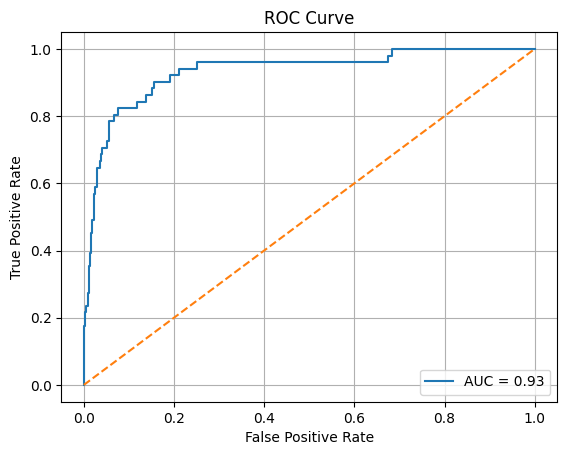

In [133]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_proba = lgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

**Explainability techniques**

In [103]:
pip install xgboost scikit-learn lime shap matplotlib pandas

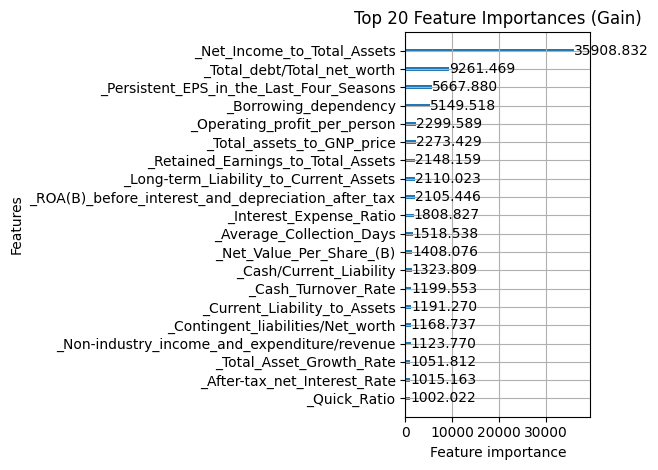

In [134]:
# 1. Feature Importance Plot
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plot feature importance (Gain)
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)
plt.title('Top 20 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

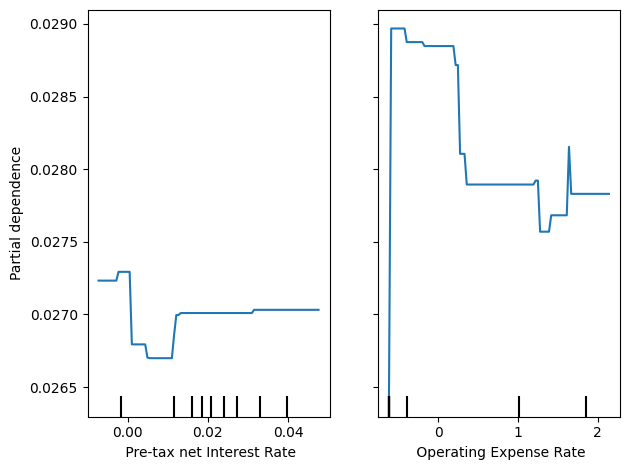

In [135]:
# 2. Partial Dependence Plot (PDP)
features_to_plot = [6, 10]  # Change based on your most important features
PartialDependenceDisplay.from_estimator(lgb_model, X_test, features_to_plot)
plt.tight_layout()
plt.show()

In [136]:
# 3. LIME Explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)
i = 5  # Index of sample to explain
exp = explainer.explain_instance(X_test.iloc[i].values, lgb_model.predict_proba, num_features=5)
print("LIME explanation for sample", i)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LIME explanation for sample 5


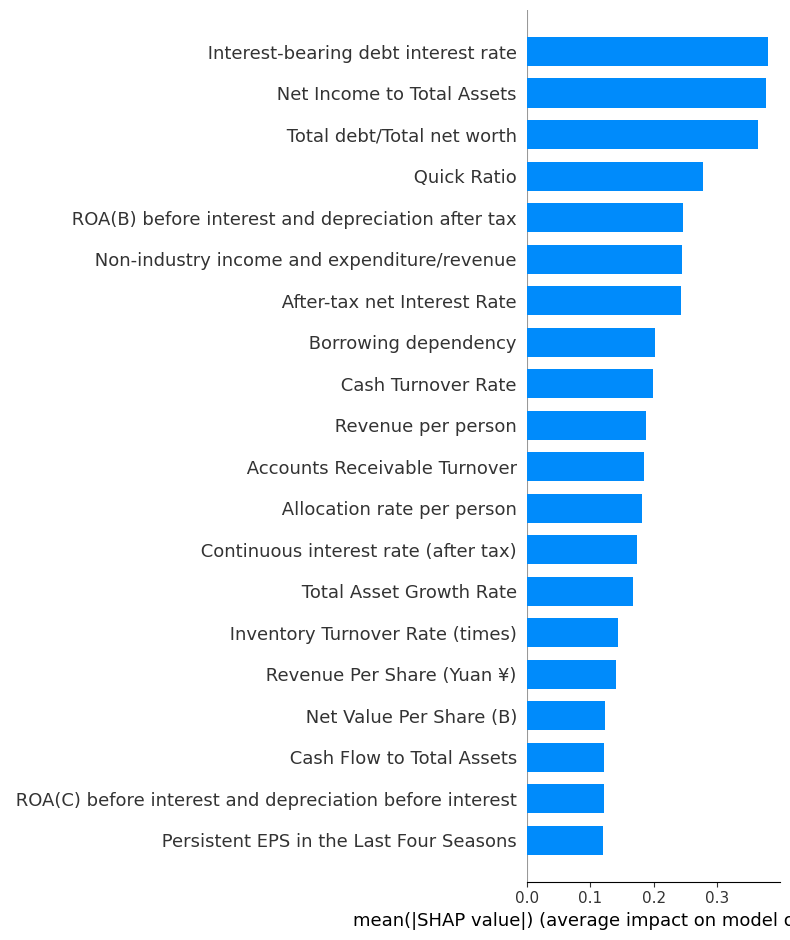

In [137]:
# 4. SHAP Explanation
import shap

# Use TreeExplainer for LightGBM
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

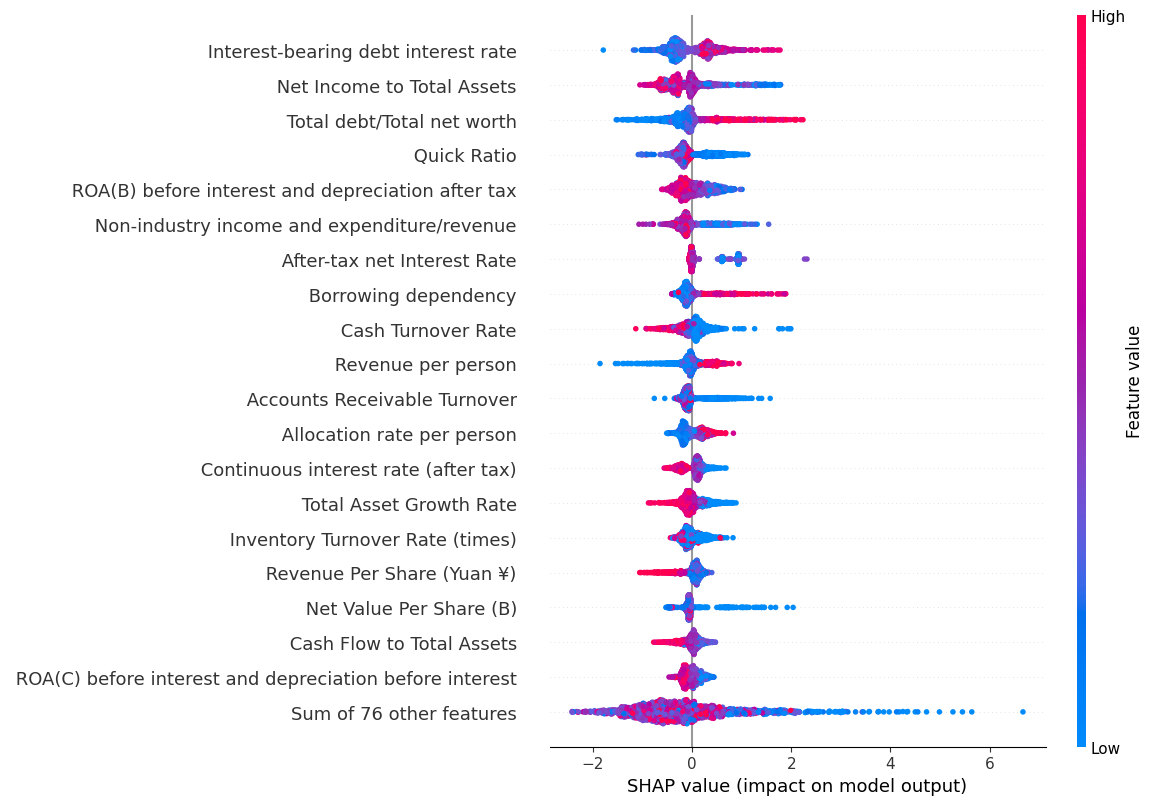

In [138]:
# Summary plot (global feature impact)
shap.plots.beeswarm(shap_values, max_display=20)

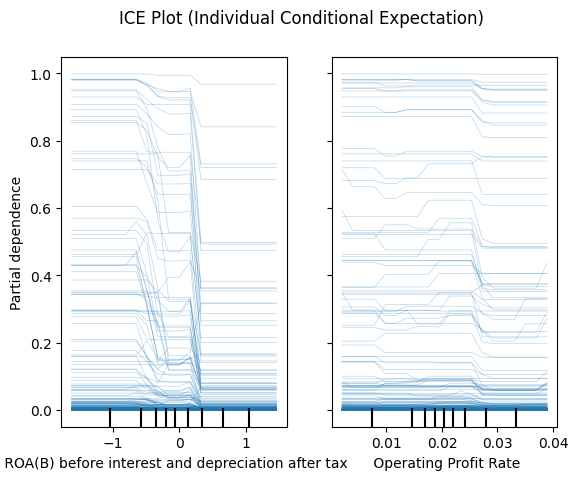

In [140]:
# ICE Plot
features = [2, 5]  # Choose features
PartialDependenceDisplay.from_estimator(
    lgb_model,
    X_test,
    features,
    kind='individual',
    grid_resolution=20
)
plt.suptitle("ICE Plot (Individual Conditional Expectation)")
plt.show()

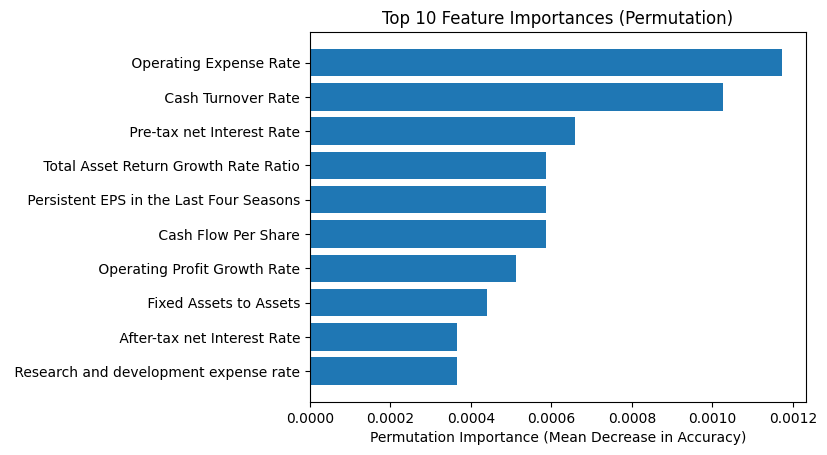

In [141]:
# 2. Permutation Feature Importance
perm_result = permutation_importance(
    lgb_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)

# Show top 10 features
sorted_idx = perm_result.importances_mean.argsort()[::-1][:10]
plt.barh(np.array(X.columns)[sorted_idx], perm_result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in Accuracy)")
plt.title("Top 10 Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.show()

**RFE "Recursive Feature Elimination"**

It's a feature selection technique that helps to choose the most important features from your dataset.

The mechanism:
beggin with all your features, trains a model, Then removes least important feature for it, and repeats this process recursively until the desired number of features is left.

In [111]:
selector = RFE(estimator=lgb_model, n_features_to_select=10)
selector.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23675
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23675
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23420
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23420
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23165
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22910
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22655
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22400
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22145
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21890
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21635
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21380
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21125
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20870
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20615
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20360
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20105
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19850
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19595
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19340
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19085
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18830
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18575
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18320
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18065
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17810
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17555
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17300
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17045
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16790
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16535
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16280
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16025
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15810
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15555
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14025
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13770
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


RFE(estimator=LGBMClassifier(metric='auc', objective='binary', random_state=42,
                             scale_pos_weight=31.27810650887574),
    n_features_to_select=10)

In [112]:
#Selected features
selected_features = X.columns[selector.support_]
print(" Selected Features:\n", selected_features)

 Selected Features:
 Index([' Interest-bearing debt interest rate',
       ' Persistent EPS in the Last Four Seasons',
       ' Revenue Per Share (Yuan ¥)', ' Total debt/Total net worth',
       ' Inventory Turnover Rate (times)', ' Revenue per person',
       ' Quick Assets/Total Assets', ' Current Liabilities/Liability',
       ' Quick Asset Turnover Rate', ' Cash Turnover Rate'],
      dtype='object')


In [113]:
#Reduce train/test to selected features
X_train_rfe = X_train_scaled[:, selector.support_]
X_test_rfe = X_test_scaled[:, selector.support_]

In [114]:
lgb_model.fit(X_train_rfe, y_train)

[LightGBM] [Info] Number of positive: 169, number of negative: 5286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030981 -> initscore=-3.442918
[LightGBM] [Info] Start training from score -3.442918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(metric='auc', objective='binary', random_state=42,
               scale_pos_weight=31.27810650887574)

In [115]:
#Permutation Importance on the selected features
results = permutation_importance(
    lgb_model, X_test_rfe, y_test,
    n_repeats=10, random_state=42, scoring='f1')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [144]:
#Map importance scores to selected features
importance_scores = pd.Series(results.importances_mean, index=selected_features)
print("\n -Permutation Importance:")
print(importance_scores.sort_values(ascending=False))



 -Permutation Importance:
Persistent EPS in the Last Four Seasons    0.283516
Total debt/Total net worth                 0.263980
Interest-bearing debt interest rate        0.066881
Cash Turnover Rate                         0.038413
Revenue Per Share (Yuan ¥)                 0.035956
Quick Assets/Total Assets                 -0.004330
Current Liabilities/Liability             -0.007336
Revenue per person                        -0.010799
Inventory Turnover Rate (times)           -0.051871
Quick Asset Turnover Rate                 -0.070327
dtype: float64


**Plot confusion matrix**

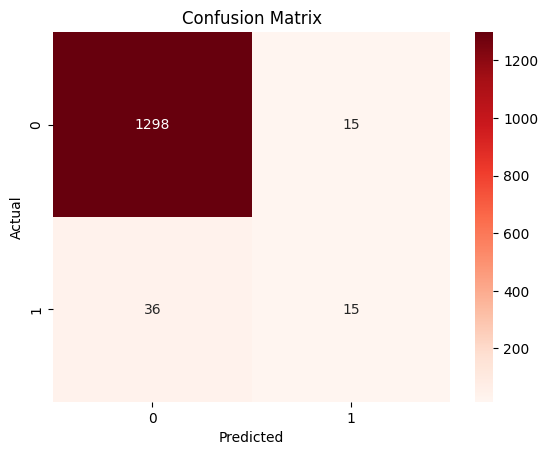

In [148]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()